In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install import_ipynb 
!conda install -c conda-forge import_ipynb

/Users/gabesmithline/miniconda3/lib/python3.10/site-packages/conda/base/context.py:200: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - import_ipynb

Current channels:

  - https://conda.anaconda.org/conda-forge
  - defaults
  - https://conda.anaconda.org/pytorch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at

In [3]:
import sys

sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field
from math import prod, sqrt
sys.path.append('../caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from prompts.make_prompt_bargain import make_prompt_bargain
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

pathology_results = pd.DataFrame()  
import itertools
envy_results_history = {}
from eval.metrics import *




Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-2p5p0kjj because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

In [4]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [5]:
import time
import pandas as pd
import torch
import numpy as np
from math import sqrt, prod

# ------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------
# prompt_style = 'llama_3.3_70b_maximize_value_outside_offer_cot_1_test'
prompt_style = 'openai_o1_maximize_value_outside_offer_cot_1_test2'
# prompt_style = 'bargain_maximize_results_outside_offer_emphasized_with_example'
# prompt_style = 'anthropic_3_opus_maximize_value_outside_offer_cot_1'
# prompt_style = 'gemini_2.0_flash_maximize_value_outside_offer_cot_.8'

date = '1_24_2025'
max_rounds = 3
games = 100
circle = 3  # TODO: Possibly loop through [0, 1, 2, 3, ...] if needed

# ------------------------------------------------------------------------
# Helper function: Discounted value
# ------------------------------------------------------------------------
def calculate_discounted_value(offer, values, gamma, realization_round):
    """
    Returns the discounted value of `offer` for an agent with utility `values`,
    discount factor `gamma`, and the realization round number.
    """
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (realization_round - 1))

# ------------------------------------------------------------------------
# Helper function: Detect pathology #4 (accepting worse than outside)
# ------------------------------------------------------------------------
def check_accepting_worse_than_outside(current_player, p1_kept, p2_kept, game):
    """
    PATHOLOGY 4: Accepting an offer worse than your outside offer.
    If the current player accepted, check if the portion they get
    is less than their outside offer.
    """
    accepting_worse = False
    action = game.players[current_player - 1].action
    if action == "ACCEPT":
        if current_player == 1 and p1_kept is not None:
            if np.dot(game.player_values[0], p1_kept) < game.outside_offer_values[0]:
                accepting_worse = True
        elif current_player == 2 and p2_kept is not None:
            if np.dot(game.player_values[1], p2_kept) < game.outside_offer_values[1]:
                accepting_worse = True
    return accepting_worse

# ------------------------------------------------------------------------
# Helper function: Detect pathology #5 (walking away from a better offer)
# ------------------------------------------------------------------------
def check_walking_away_from_better(current_player, p1_kept, p2_kept, game):
    """
    PATHOLOGY 5: Walking away from an offer better than your outside offer.
    """
    walking_away_better = False
    action = game.players[current_player - 1].action
    if ("WALK" in action) or (
        current_player == 2
        and action == "COUNTEROFFER"
        and game.current_round == game.max_rounds
    ):
        if current_player == 1 and p1_kept is not None:
            if np.dot(game.player_values[0], p1_kept) > game.outside_offer_values[0]:
                walking_away_better = True
        elif current_player == 2 and p2_kept is not None:
            if np.dot(game.player_values[1], p2_kept) > game.outside_offer_values[1]:
                walking_away_better = True
    return walking_away_better

# ------------------------------------------------------------------------
# Helper function: Determine validity of a WALK
# ------------------------------------------------------------------------
def determine_walk_away_type(current_player, game):
    """
    Checks if the current player's action is 'INVALID WALK' or 'WALK'
    and returns an appropriate walk_away_type. Otherwise returns None.
    """
    action = game.players[current_player - 1].action
    if "INVALID WALK" in action:
        return "INVALID"
    elif "WALK" in action:
        return "VALID"
    return None

# ------------------------------------------------------------------------
# Helper function: Update who-keeps-what (p1_kept, p2_kept)
# ------------------------------------------------------------------------
def update_kept_portions(current_player, game, p1_kept, p2_kept):
    """
    If there's a new COUNTEROFFER from the current player, update
    p1_kept and p2_kept accordingly.
    """
    action = game.players[current_player - 1].action
    if action == "COUNTEROFFER":
        if current_player == 1:
            # P1 is proposing, so P1's kept portion is whatever is left
            # and P2 is offered game.current_offer.offer
            p1_kept = game.items - np.array(game.current_offer.offer)
            p2_kept = np.array(game.current_offer.offer)
        else:  # current_player == 2
            # P2 is proposing, so P2's kept portion is whatever is left
            # and P1 is offered game.current_offer.offer
            p1_kept = np.array(game.current_offer.offer)
            p2_kept = game.items - np.array(game.current_offer.offer)
    return p1_kept, p2_kept

# ------------------------------------------------------------------------
# Helper function: Final round resolution
# ------------------------------------------------------------------------
def handle_final_round(
    i,
    current_round,
    current_player,
    game,
    prev_offer,
    p1_kept,
    p2_kept,
    p1_values,
    p2_values,
    p1_offers,
    accepting_an_offer_worse_than_outside_offer
):
    """
    If we are at the final round and it's Player 2's turn, handle
    accept/counter/walk logic, finalize payoffs, print results,
    and stop the game.
    """
    # If there's a new offer and it's not the same as the previous
    # -> P2 has effectively made a final COUNTEROFFER
    if game.current_offer and game.current_offer != prev_offer:
        print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
        p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
        p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
        print("\nGame ended after max rounds - both players get outside offers")

    # If there's an offer and it matches the previous offer -> P2 ACCEPT
    elif game.current_offer == prev_offer:
        print("\nPlayer 2's final action: ACCEPT")
        # P2 accepted P1's final offer
        p1_kept = game.items - np.array(game.current_offer.offer)
        p1_value = calculate_discounted_value(
            p1_kept, game.player_values[0], game.gamma, current_round
        )
        p2_value = calculate_discounted_value(
            game.current_offer.offer, game.player_values[1], game.gamma, current_round
        )
        # Check pathology #4 after final acceptance
        if game.outside_offer_values[1] > np.dot(game.player_values[1], p1_offers[-1]):
            accepting_an_offer_worse_than_outside_offer = True

    else:
        # P2 walked away
        print("\nPlayer 2's final action: WALK")
        p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
        p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
        print("\nGame ended after max rounds - both players get outside offers")

    # Mark game as ended
    game.in_progress = False
    print(f"\nRound {current_round} Final Values:")
    print(f"Player 1: {p1_value:.2f}")
    print(f"Player 2: {p2_value:.2f}")

    p1_values.append(p1_value)
    p2_values.append(p2_value)

    return p1_kept, p2_kept, p1_values, p2_values, accepting_an_offer_worse_than_outside_offer

In [6]:

# ------------------------------------------------------------------------
# Main script
# ------------------------------------------------------------------------
rounds = []
p1_values = []
p2_values = []
pathology_results = pd.DataFrame()
envy_results_history = {}

for i in range(games):
    # Print progress / rate-limit
    if (i + 1) % 10 == 0:
        print(f"Game {i + 1} of {games}")
        time.sleep(2 * 60)  # Sleep for 2 minutes
    
    # Reset per-game trackers
    rounds = []
    p1_values = []
    p2_values = []
    p1_offers = []
    p2_offers = []
    p1_offers_utility = []
    p2_offers_utility = []
    p1_kept = None
    p2_kept = None

    # Initialize game & game history
    game = NegotitaionGame(
        player1_agent=llm_agent.LLMAgent(llm_type="openai", player_num=0),
        player2_agent=llm_agent.LLMAgent(llm_type="openai", player_num=1),
        num_items=5,
        item_value_range=[1, 101],
        gamma=0.9,
        max_rounds=max_rounds,
        circle=circle
    )

    game_history = GameHistory(
        agent_1_name="Agent1",
        agent_2_name="Agent2",
        num_items=game.num_items,
        items=torch.tensor(game.items),
        agent_1_values=torch.tensor(game.player_values[0]),
        agent_2_values=torch.tensor(game.player_values[1]),
        agent_1_outside_value=game.outside_offer_values[0],
        agent_2_outside_value=game.outside_offer_values[1]
    )
    game_history.agent_1_offers = []
    game_history.agent_2_offers = []

    # Prepare a DataFrame to record step-by-step results
    game.game_results = pd.DataFrame(columns=[
        "game_num", "round_num", "player", "discount_rate", "offer", "value",
        "undiscounted_value", "items", "your_side_of_current_offer",
        "outside_offer", "outside_offer_undiscounted",
        "accepting_an_offer_worse_than_outside_offer",
        "making_an_offer_worse_for_you_than_your_outside_offer",
        "walking_away_from_an_offer_better_than_your_outside_offer",
        "offer_no_items_or_all_items", "making_offer_worse_than_previous",
        "nash_welfare", "proposal_proportion_player_1",
        "proposal_proportion_player_2", "concession_size",
        "security_level_player_1", "security_level_player_2",
        "average_concession_size", "rawlsian_welfare", "gini_coefficient",
        "utilitarian_welfare", "jain_fairness_index",
        "on_pareto_frontier", "av" "mean_absolute_difference",
        "walk_type"
    ])

    print(f"PLAYING GAME_NUM: {i}")

    # (Optional) check whether previous game results exist
    if i > 0:
        print("Unique games in pathology_results:", pathology_results['game_num'].unique())
        if i - 1 in pathology_results['game_num'].unique():
            print(f"Game {i - 1} exists in pathology_results")
        else:
            print(f"Game {i - 1} does not exist in pathology_results")
            #break

    # Compute Pareto frontier for the game
    pareto_front = compute_pareto_frontier(
        game.player_values[0],
        game.player_values[1],
        game.num_items,
        game.items,
        game.outside_offer_values
    )

    # --------------------------------------------------------------------
    # Main negotiation loop
    # -------------------------------------------------------------------- 
    while game.in_progress:
        time.sleep(5)  # Sleep 5s to simulate thinking or rate-limit
        current_step = len(game.history[0]) + len(game.history[1]) + 1
        current_round = (current_step - 1) // 2 + 1
        current_player = 1 if current_step % 2 == 1 else 2
        game.current_round = current_round

        # Pathology flags
        making_offer_worse_than_previous = False
        making_offer_worse_than_outside_offer = False
        offer_no_items_or_all_items = False
        accepting_an_offer_worse_than_outside_offer = False
        walking_away_from_an_offer_better_than_outside_offer = False
        walk_away_type = None
        your_side_of_current_offer = None

        print("\n" + "=" * 80)
        print(f"Game {i + 1}, Round {current_round}, Player {current_player}'s turn (Step {current_step})")
        print("=" * 80)

        # Remember the previous offer, let the current player move
        prev_offer = game.current_offer
        game.step()

        # Check pathologies #4 (accepting worse) and #5 (walking away from better)
        walking_away_from_an_offer_better_than_outside_offer = check_walking_away_from_better(
            current_player, p1_kept, p2_kept, game
        )
        accepting_an_offer_worse_than_outside_offer = check_accepting_worse_than_outside(
            current_player, p1_kept, p2_kept, game
        )

        # Check for walk away type (valid/invalid/no walk)
        walk_away_type = determine_walk_away_type(current_player, game)

        # If there's a current offer, compute new values and pathologies
        if game.current_offer:
            # Determine realization round for each player
            action = game.players[current_player - 1].action
            if action == "COUNTEROFFER":
                if current_player == 1:
                    realization_round_p1 = current_round
                    realization_round_p2 = current_round
                else:
                    realization_round_p1 = current_round + 1
                    realization_round_p2 = current_round + 1
            else:
                # For ACCEPT or other actions, realization is the current round
                realization_round_p1 = current_round
                realization_round_p2 = current_round

            # Update p1_kept, p2_kept if the current player made a counteroffer
            p1_kept, p2_kept = update_kept_portions(current_player, game, p1_kept, p2_kept)

            # Track undiscounted utilities
            p1_offers_utility.append(np.dot(game.player_values[0], p1_kept))
            p2_offers_utility.append(np.dot(game.player_values[1], p2_kept))

            # Discounted values
            p1_value = calculate_discounted_value(
                p1_kept, game.player_values[0], game.gamma, realization_round_p1
            )
            p2_value = calculate_discounted_value(
                p2_kept, game.player_values[1], game.gamma, realization_round_p2
            )

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)

            # Track which player's offer it is
            if current_player == 1:
                p1_offers.append(game.current_offer.offer)
            else:
                p2_offers.append(game.current_offer.offer)
                print(f"\nRound {current_round} Values:")
                print(f"Player 1: {p1_value:.2f}")
                print(f"Player 2: {p2_value:.2f}")

            # ------------------------------
            # Pathology #1: Offer is worse than the immediate previous offer
            # ------------------------------
            if action == "COUNTEROFFER":
                # We can only compare if there's a previous offer for the same player
                if (current_round == 1 and current_player == 2) or (current_round > 1):
                    if current_player == 1:
                        your_side_of_previous_offer = p1_values[-2]
                        your_side_of_current_offer = p1_values[-1]
                    else:
                        your_side_of_previous_offer = p2_values[-2]
                        your_side_of_current_offer = p2_values[-1]

                    making_offer_worse_than_previous = (
                        your_side_of_previous_offer > your_side_of_current_offer
                    )

                # ------------------------------
                # Pathology #2: Offer is worse than your outside offer
                # ------------------------------
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    making_offer_worse_than_outside_offer = (p1_value < outside_offer)
                else:  # current_player == 2
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** current_round)
                    making_offer_worse_than_outside_offer = (p2_value < outside_offer)
            else:
                making_offer_worse_than_outside_offer = False

            # ------------------------------
            # Pathology #3: Offer has no items or all items
            # ------------------------------
            if action == "COUNTEROFFER":
                if (np.array_equal(game.current_offer.offer, [0] * game.num_items) or
                        np.array_equal(game.current_offer.offer, game.items)):
                    offer_no_items_or_all_items = True

            # ------------------------------
            # Compute Nash welfare
            # ------------------------------
            if action in ("ACCEPT", "COUNTEROFFER"):
                nash_welfare = sqrt(prod([
                    np.dot(game.player_values[0], p1_kept),
                    np.dot(game.player_values[1], p2_kept)
                ]))
            else:
                nash_welfare = sqrt(prod([
                    game.outside_offer_values[0],
                    game.outside_offer_values[1]
                ]))

            # ------------------------------------------------------------
            # Utility proportion for the round (x1_prop, x2_prop) – example usage
            # ------------------------------------------------------------
            if "WALK" in action:
                x1_prop = game.outside_offer_values[0]
                x2_prop = game.outside_offer_values[1]
            else:
                # Normalize by total utility for that player + item draws
                x1_prop = (
                    np.dot(game.player_values[0], p1_kept)
                    / sum([np.dot(game.player_values[0], p1_kept),
                           np.dot(game.player_values[0], game.num_items)])
                )
                x2_prop = (
                    np.dot(game.player_values[1], p2_kept)
                    / sum([np.dot(game.player_values[1], p2_kept),
                           np.dot(game.player_values[1], game.num_items)])
                )

            # ------------------------------------------------------------
            # Concession size
            # ------------------------------------------------------------
            concession_size = None
            if action == "COUNTEROFFER" and game.current_round > 1:
                if current_player == 1:
                    old_value = p1_offers_utility[-1] if p1_offers_utility else np.dot(game.player_values[0], p1_kept)
                    new_value = p1_offers_utility[-1]
                    concession_size = max(0, old_value - new_value)
                    p1_offers_utility.append(new_value)
                else:
                    old_value = p2_offers_utility[-1] if p2_offers_utility else np.dot(game.player_values[1], p2_kept)
                    new_value = np.dot(game.player_values[1], p2_kept)
                    concession_size = max(0, old_value - new_value)
                    p2_offers_utility.append(new_value)
            else:
                if action == "COUNTEROFFER":
                    if current_player == 1 and not p1_offers_utility:
                        p1_offers_utility.append(np.dot(game.player_values[0], p1_kept))
                    elif current_player == 2 and not p2_offers_utility:
                        p2_offers_utility.append(np.dot(game.player_values[1], p2_kept))

            # ------------------------------------------------------------
            # Proportion of collective value for each player
            # ------------------------------------------------------------
            if "WALK" in action:
                proportion_of_value_p1 = None
                proportion_of_value_p2 = None
            else:
                denom = (np.dot(game.player_values[0], p1_kept)
                         + np.dot(game.player_values[1], p2_kept))
                if denom > 0:
                    proportion_of_value_p1 = np.dot(game.player_values[0], p1_kept) / denom
                    proportion_of_value_p2 = np.dot(game.player_values[1], p2_kept) / denom
                else:
                    proportion_of_value_p1 = 0.0
                    proportion_of_value_p2 = 0.0

            # ------------------------------------------------------------
            # Proportional share of the maximum available utility
            # ------------------------------------------------------------
            if "WALK" in action:
                proposal_proportion_player_1_available_items = None
                proposal_proportion_player_2_available_items = None
            else:
                total_p1_available_items = np.dot(game.player_values[0], game.items)
                total_p2_available_items = np.dot(game.player_values[1], game.items)

                proposal_proportion_player_1_available_items = (
                    np.dot(game.player_values[0], p1_kept) / total_p1_available_items
                ) if total_p1_available_items else 0.0

                proposal_proportion_player_2_available_items = (
                    np.dot(game.player_values[1], p2_kept) / total_p2_available_items
                ) if total_p2_available_items else 0.0

            # ------------------------------------------------------------
            # Utilitarian & Rawlsian welfare
            # ------------------------------------------------------------
            if "WALK" in action:
                utilitarian_welfare = sum(game.outside_offer_values)
                rawlsian_welfare = min(game.outside_offer_values[0], game.outside_offer_values[1])
            else:
                utilitarian_welfare = (
                    np.dot(game.player_values[0], p1_kept)
                    + np.dot(game.player_values[1], p2_kept)
                )
                rawlsian_welfare = min(
                    np.dot(game.player_values[0], p1_kept),
                    np.dot(game.player_values[1], p2_kept)
                )

            # ------------------------------------------------------------
            # Gini Coefficient (n=2)
            # ------------------------------------------------------------
            if "WALK" in action:
                wealth_distribution = np.array([
                    game.outside_offer_values[0],
                    game.outside_offer_values[1]
                ], dtype=float)
            else:
                wealth_distribution = np.array([
                    np.dot(p1_kept, game.player_values[0]),
                    np.dot(p2_kept, game.player_values[1])
                ], dtype=float)

            total_wealth = wealth_distribution.sum()
            jain_fairness_index = None 
            if total_wealth > 0:
                x1, x2 = wealth_distribution
                numerator = abs(x1 - x2)
                denominator = 4.0 * total_wealth
                gini_coefficient = numerator / denominator
            else:
                gini_coefficient = 0.0

                # ------------------------------------------------------------
                # Jain's Fairness Index Calculation
                # ------------------------------------------------------------

                # Calculate x1 and x2
                if "WALK" in action:
                    x1 = game.outside_offer_values[0]
                    x2 = game.outside_offer_values[1]
                else:
                    x1 = np.dot(p1_kept, game.player_values[0])
                    x2 = np.dot(p2_kept, game.player_values[1])

                # Mean Utility
                mean_utility = (x1 + x2) / 2.0

                # Variance
                variance_value = (x1**2 + x2**2) / 2.0 - mean_utility**2
                if variance_value < 0:
                    variance_value = 0.0  # Correct for possible negative variance due to precision

                # Coefficient of Variation
                if mean_utility != 0:
                    coefficient_of_variation = np.sqrt(variance_value) / mean_utility
                else:
                    coefficient_of_variation = 0.0  # Avoid division by zero

                # Jain's Fairness Index
                jain_fairness_index = 1 / (1 + coefficient_of_variation ** 2)

            # ------------------------------------------------------------
            # Security Level
            # ------------------------------------------------------------
            if "WALK" in action:
                security_level_player_1 = 0
                security_level_player_2 = 0
            else:
                security_level_player_1 = max(
                    0, game.outside_offer_values[0] - np.dot(game.player_values[0], p1_kept)
                )
                security_level_player_2 = max(
                    0, game.outside_offer_values[1] - np.dot(game.player_values[1], p2_kept)
                )

            # ------------------------------------------------------------
            # On Pareto Frontier?
            # ------------------------------------------------------------
            on_pareto_frontier = False
            for vals in pareto_front:
                if vals["type"] == "outside_offer":
                    '''
                    A WALK was played and the outside offers lie on the frontier
                    '''
                    if "WALK" in game.players[current_player - 1].action: 
                        on_pareto_frontier = True
                        break
                elif vals["type"] == "allocation":
                    if (np.array_equal(vals["agent1"], p1_kept)
                        and np.array_equal(vals["agent2"], p2_kept)):
                        on_pareto_frontier = True
                        break

            # ------------------------------------------------------------
            # Mean Absolute Difference (MAD)
            # ------------------------------------------------------------
            if "WALK" in action:
                x1 = game.outside_offer_values[0]
                x2 = game.outside_offer_values[1]
            else:
                x1 = np.dot(game.player_values[0], p1_kept)
                x2 = np.dot(game.player_values[1], p2_kept)

            if x1 == 0.0 and x2 == 0.0:
                mean_absolute_difference = 0.0
            else:
                mean_absolute_difference = abs(x1 - x2) / 2.0

            # ------------------------------------------------------------
            # Record step in the DataFrame
            # ------------------------------------------------------------
            new_row = pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": game.current_offer.offer,
                "value": (p1_value if current_player == 1 else p2_value),
                "undiscounted_value": (
                    p1_value / (game.gamma ** (current_round - 1))
                    if current_player == 1
                    else p2_value / (game.gamma ** (current_round - 1))
                ),
                "items": game.items,
                "your_side_of_current_offer": your_side_of_current_offer,
                "outside_offer": (
                    outside_offer if action == "COUNTEROFFER" else None
                ),
                "outside_offer_undiscounted": game.outside_offer_values[current_player - 1],
                "accepting_an_offer_worse_than_outside_offer":
                    accepting_an_offer_worse_than_outside_offer,
                "making_an_offer_worse_for_you_than_your_outside_offer":
                    making_offer_worse_than_outside_offer,
                "walking_away_from_an_offer_better_than_your_outside_offer":
                    walking_away_from_an_offer_better_than_outside_offer,
                "offer_no_items_or_all_items": offer_no_items_or_all_items,
                "making_offer_worse_than_previous": making_offer_worse_than_previous,
                "nash_welfare": nash_welfare,
                "proposal_proportion_player_1_available_items":
                    proposal_proportion_player_1_available_items,
                "proposal_proportion_player_2_available_items":
                    proposal_proportion_player_2_available_items,
                "concession_size": concession_size,
                "security_level_player_1": security_level_player_1,
                "security_level_player_2": security_level_player_2,
                "average_concession_size": None,  # TODO: compute post-game
                "utilitarian_welfare": utilitarian_welfare,
                "rawlsian_welfare": rawlsian_welfare,
                "gini_coefficient": gini_coefficient,
                "jain_fairness_index": jain_fairness_index,
                "on_pareto_frontier": on_pareto_frontier,
                "mean_absolute_difference": mean_absolute_difference,
                "walk_away_type": walk_away_type
            }])
            game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)

        # ---------------------------------------------------------
        # Add the current offer to the game history if complete
        # ---------------------------------------------------------
        if game.current_offer is not None and len(game.current_offer.offer) == game.num_items:
            game_history.add_offer(
                game.current_player,
                Offer(game.current_player, offer=torch.tensor(game.current_offer.offer))
            )

        # ---------------------------------------------------------
        # Check final-round logic (Player 2's turn on last round)
        # --------------------------------------------------------- 
        if current_round == game.max_rounds and current_player == 2:
            # Handle acceptance/walk/counter in final round
            p1_kept, p2_kept, p1_values, p2_values, accepting_an_offer_worse_than_outside_offer = (
                handle_final_round(
                    i,
                    current_round,
                    current_player,
                    game,
                    prev_offer,
                    p1_kept,
                    p2_kept,
                    p1_values,
                    p2_values,
                    p1_offers,
                    accepting_an_offer_worse_than_outside_offer
                )
            )
            break

        # ---------------------------------------------------------
        # Check if Player 1 walked away (offer is None + "WALK")
        # ---------------------------------------------------------
        elif (game.current_offer is None
              and current_player == 1
              and "WALK" in game.players[current_player - 1].action):
            print("Player 1 walked")
            # Record a final row for the walk
            new_row = pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": [],
                "value": None,
                "items": game.items,
                "your_side_of_current_offer": None,
                "outside_offer": None,
                "accepting_an_offer_worse_than_outside_offer":
                    accepting_an_offer_worse_than_outside_offer,
                "making_an_offer_worse_for_you_than_your_outside_offer":
                    making_offer_worse_than_outside_offer,
                "walking_away_from_an_offer_better_than_your_outside_offer":
                    walking_away_from_an_offer_better_than_outside_offer,
                "offer_no_items_or_all_items": offer_no_items_or_all_items,
                "making_offer_worse_than_previous": making_offer_worse_than_previous,
                "security_level_player_1": 0,
                "security_level_player_2": 0,
                "average_concession_size": None,
                "nash_welfare": sqrt(prod([
                    game.outside_offer_values[0],
                    game.outside_offer_values[1]
                ])),
                "utilitarian_welfare":
                    game.outside_offer_values[0] + game.outside_offer_values[1],
                "rawlsian_welfare":
                    min(game.outside_offer_values[0], game.outside_offer_values[1]),
                "gini_coefficient": (
                    abs(game.outside_offer_values[0] - game.outside_offer_values[1]) /
                    (4.0 * sum([game.outside_offer_values[0], game.outside_offer_values[1]]))
                ) if sum(game.outside_offer_values) > 0 else 0.0,
                "security_level_player_1": 0,
                "security_level_player_2": 0,
                "jain_fairness_index": None,
                "proposal_proportion_player_1": None,
                "proposal_proportion_player_2": None,
                "concession_size": None,
                "on_pareto_frontier": False,
                "mean_absolute_difference":
                    abs(game.outside_offer_values[0] - game.outside_offer_values[1]) / 2.0,
                "walk_away_type": walk_away_type
            }])
            game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)

            game.in_progress = False

    # After the game loop ends, record the results
    pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)
    envy_results_history[i] = game_history

# ------------------------------------------------------------------------
# Save results
# ------------------------------------------------------------------------
pathology_results.to_csv(
    f'pathology_results_{date}_{games}_{prompt_style}_circle_{circle}.csv',
    index=False
)

# If you want to save envy_results_history as well:
# pd.DataFrame.from_dict(envy_results_history, orient='index').to_csv(
#     f'envy_results_{date}_{games}_{prompt_style}.csv', 
#     index=False
# )


PLAYING GAME_NUM: 0

Game 1, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 6 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 43 for item 1, 26 for item 2, 34 for item 3, 94 for item 4, 22 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 939. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 166. Your objective is to maximize your value

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 1, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 6 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 63 for item 1, 69 for item 2, 85 for item 3, 76 for item 4, 6 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1354. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 103. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 1, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 6 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 43 for item 1, 26 for item 2, 34 for item 3, 94 for item 4, 22 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 939. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 166. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 2, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 6 units of item 2, 6 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 49 for item 1, 57 for item 2, 36 for item 3, 4 for item 4, 76 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 945. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 44. Your objective is to maximize your value of the outcome of the

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 2, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 6 units of item 2, 6 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 5 for item 1, 2 for item 2, 83 for item 3, 32 for item 4, 38 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 735. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 480. Your objective is to maximize your value of the outcome of the

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 2, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 6 units of item 2, 6 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 49 for item 1, 57 for item 2, 36 for item 3, 4 for item 4, 76 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 945. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 44. Your objective is to maximize your value of the outcome of the

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 3, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 7 units of item 2, 4 units of item 3, 4 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 39 for item 1, 6 for item 2, 23 for item 3, 19 for item 4, 81 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 735. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 401. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 3, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 7 units of item 2, 4 units of item 3, 4 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 88 for item 1, 76 for item 2, 96 for item 3, 86 for item 4, 63 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1726. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1614. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 3, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 7 units of item 2, 4 units of item 3, 4 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 39 for item 1, 6 for item 2, 23 for item 3, 19 for item 4, 81 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 735. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 401. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 4, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 4 units of item 3, 7 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 53 for item 1, 51 for item 2, 26 for item 3, 77 for item 4, 24 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1111. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 582. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 4, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 4 units of item 3, 7 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 35 for item 1, 6 for item 2, 21 for item 3, 20 for item 4, 23 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 492. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 140. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 4, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 4 units of item 3, 7 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 53 for item 1, 51 for item 2, 26 for item 3, 77 for item 4, 24 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1111. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 582. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 5, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 4 units of item 2, 6 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 99 for item 1, 35 for item 2, 43 for item 3, 19 for item 4, 18 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 664. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 283. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 5, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 4 units of item 2, 6 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 31 for item 1, 22 for item 2, 58 for item 3, 55 for item 4, 19 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 818. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 774. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 6, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 10 units of item 1, 4 units of item 2, 4 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 59 for item 1, 85 for item 2, 54 for item 3, 3 for item 4, 14 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1228. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 442. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 6, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 10 units of item 1, 4 units of item 2, 4 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 72 for item 1, 5 for item 2, 28 for item 3, 94 for item 4, 27 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1363. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 476. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 7, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 6 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 89 for item 1, 84 for item 2, 61 for item 3, 91 for item 4, 21 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1791. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 255. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 7, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 6 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 7 for item 1, 10 for item 2, 5 for item 3, 19 for item 4, 56 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 490. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 53. Your objective is to maximize your value of the outcome of the 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 8, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 3 units of item 3, 6 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 10 for item 1, 89 for item 2, 49 for item 3, 85 for item 4, 38 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1233. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 46. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 8, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 3 units of item 3, 6 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 38 for item 1, 13 for item 2, 72 for item 3, 33 for item 4, 84 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1000. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 795. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 9, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 1 units of item 2, 4 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 99 for item 1, 82 for item 2, 93 for item 3, 74 for item 4, 50 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1347. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 225. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 9, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 1 units of item 2, 4 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 21 for item 1, 51 for item 2, 62 for item 3, 62 for item 4, 45 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 753. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 132. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


PLAYING GAME_NUM: 9
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8]
Game 8 exists in pathology_results

Game 10, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 5 units of item 3, 5 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 81 for item 1, 75 for item 2, 69 for item 3, 53 for item 4, 45 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1492. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 10, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 5 units of item 3, 5 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 54 for item 1, 82 for item 2, 46 for item 3, 81 for item 4, 45 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1349. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 936. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 10, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 5 units of item 3, 5 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 81 for item 1, 75 for item 2, 69 for item 3, 53 for item 4, 45 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1492. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 388. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 11, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 8 units of item 3, 11 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 32 for item 1, 78 for item 2, 60 for item 3, 98 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 2280. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 251. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 11, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 8 units of item 3, 11 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 68 for item 1, 7 for item 2, 95 for item 3, 52 for item 4, 23 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1770. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 122. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 12, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 2 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 61 for item 1, 67 for item 2, 43 for item 3, 29 for item 4, 87 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 908. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 352. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 12, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 2 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 11 for item 1, 83 for item 2, 74 for item 3, 40 for item 4, 6 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 619. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 512. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 12, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 2 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 61 for item 1, 67 for item 2, 43 for item 3, 29 for item 4, 87 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 908. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 352. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 13, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 7 units of item 2, 3 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 5 for item 1, 72 for item 2, 28 for item 3, 47 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 942. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 363. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 13, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 7 units of item 2, 3 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 73 for item 1, 88 for item 2, 84 for item 3, 85 for item 4, 88 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1840. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 445. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 14, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 8 units of item 2, 4 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 20 for item 1, 21 for item 2, 53 for item 3, 4 for item 4, 10 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 510. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 504. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 14, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 8 units of item 2, 4 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 100 for item 1, 30 for item 2, 24 for item 3, 15 for item 4, 77 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1096. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 991. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 14, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 8 units of item 2, 4 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 20 for item 1, 21 for item 2, 53 for item 3, 4 for item 4, 10 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 510. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 504. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 15, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 2 units of item 2, 1 units of item 3, 5 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 43 for item 1, 30 for item 2, 70 for item 3, 99 for item 4, 44 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1104. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 269. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 15, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 2 units of item 2, 1 units of item 3, 5 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 90 for item 1, 10 for item 2, 92 for item 3, 82 for item 4, 70 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1392. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 96. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 16, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 9 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 6 for item 1, 54 for item 2, 68 for item 3, 55 for item 4, 83 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1183. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 806. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 16, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 9 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 81 for item 1, 23 for item 2, 42 for item 3, 94 for item 4, 83 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1282. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 86. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 17, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 0 units of item 3, 6 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 86 for item 1, 37 for item 2, 83 for item 3, 86 for item 4, 97 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1456. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1128. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 17, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 0 units of item 3, 6 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 79 for item 1, 55 for item 2, 13 for item 3, 16 for item 4, 76 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 957. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 18. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 18, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 3 units of item 3, 1 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 52 for item 1, 97 for item 2, 11 for item 3, 4 for item 4, 99 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 727. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 562. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 18, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 3 units of item 3, 1 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 64 for item 1, 72 for item 2, 83 for item 3, 67 for item 4, 86 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 904. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 249. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 19, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 66 for item 1, 83 for item 2, 47 for item 3, 46 for item 4, 77 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1069. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 975. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 19, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 91 for item 2, 10 for item 3, 37 for item 4, 96 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 755. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 158. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


PLAYING GAME_NUM: 19
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18]
Game 18 exists in pathology_results

Game 20, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 4 units of item 3, 6 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 91 for item 1, 73 for item 2, 37 for item 3, 33 for item 4, 48 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1497. Player 2 has a private outside offer drawn from a uniform random distribution ranging

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 20, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 4 units of item 3, 6 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 55 for item 1, 38 for item 2, 52 for item 3, 32 for item 4, 23 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1035. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 658. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 20, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 4 units of item 3, 6 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 91 for item 1, 73 for item 2, 37 for item 3, 33 for item 4, 48 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1497. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1106. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 21, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 6 units of item 2, 2 units of item 3, 0 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 11 for item 1, 22 for item 2, 25 for item 3, 11 for item 4, 15 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 345. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 4. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 21, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 6 units of item 2, 2 units of item 3, 0 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 61 for item 1, 75 for item 2, 30 for item 3, 11 for item 4, 12 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1058. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 181. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 22, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 2 units of item 2, 2 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 50 for item 1, 96 for item 2, 32 for item 3, 61 for item 4, 45 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1008. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 124. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 22, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 2 units of item 2, 2 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 14 for item 2, 50 for item 3, 11 for item 4, 100 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 713. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 241. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 23, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 4 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 38 for item 1, 93 for item 2, 9 for item 3, 82 for item 4, 44 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 888. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 776. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 23, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 4 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 11 for item 1, 2 for item 2, 83 for item 3, 98 for item 4, 12 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 701. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 15. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 23, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 4 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 38 for item 1, 93 for item 2, 9 for item 3, 82 for item 4, 44 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 888. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 776. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 24, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 6 units of item 2, 7 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 70 for item 2, 53 for item 3, 14 for item 4, 71 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 916. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 159. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 24, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 6 units of item 2, 7 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 10 for item 1, 42 for item 2, 34 for item 3, 85 for item 4, 50 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 825. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 726. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 24, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 6 units of item 2, 7 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 70 for item 2, 53 for item 3, 14 for item 4, 71 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 916. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 159. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 25, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 5 units of item 3, 4 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 3 for item 1, 11 for item 2, 7 for item 3, 83 for item 4, 56 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 832. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 13. Your objective is to maximize your value of the outcome of the

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 25, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 5 units of item 3, 4 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 84 for item 1, 2 for item 2, 96 for item 3, 21 for item 4, 75 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1603. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 692. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 26, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 4 units of item 3, 6 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 32 for item 1, 66 for item 2, 91 for item 3, 86 for item 4, 84 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1640. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1035. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 26, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 4 units of item 3, 6 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 82 for item 1, 78 for item 2, 94 for item 3, 41 for item 4, 2 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1352. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 28. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 27, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 7 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 100 for item 1, 31 for item 2, 58 for item 3, 61 for item 4, 30 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1149. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 862. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 27, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 7 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 11 for item 1, 89 for item 2, 25 for item 3, 19 for item 4, 65 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1090. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1068. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 27, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 7 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 100 for item 1, 31 for item 2, 58 for item 3, 61 for item 4, 30 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1149. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 862. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 28, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 1 for item 1, 38 for item 2, 23 for item 3, 62 for item 4, 53 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 672. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 56. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 28, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 41 for item 1, 29 for item 2, 63 for item 3, 19 for item 4, 100 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 956. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 637. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 28, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 1 for item 1, 38 for item 2, 23 for item 3, 62 for item 4, 53 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 672. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 56. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 29, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 1 units of item 2, 3 units of item 3, 1 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 62 for item 1, 43 for item 2, 46 for item 3, 91 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 599. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 397. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 29, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 1 units of item 2, 3 units of item 3, 1 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 2 for item 1, 61 for item 2, 61 for item 3, 77 for item 4, 75 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 552. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 330. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 29, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 1 units of item 2, 3 units of item 3, 1 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 62 for item 1, 43 for item 2, 46 for item 3, 91 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 599. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 397. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)


PLAYING GAME_NUM: 29
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28]
Game 28 exists in pathology_results

Game 30, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 4 units of item 3, 0 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 12 for item 1, 13 for item 2, 50 for item 3, 7 for item 4, 49 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 448. Player 2 has a private outside offer drawn from a unifor

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 30, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 4 units of item 3, 0 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 49 for item 1, 56 for item 2, 24 for item 3, 35 for item 4, 31 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 616. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 444. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 30, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 4 units of item 3, 0 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 12 for item 1, 13 for item 2, 50 for item 3, 7 for item 4, 49 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 448. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 87. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 31, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 6 units of item 2, 5 units of item 3, 4 units of item 4, 8 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 43 for item 1, 73 for item 2, 55 for item 3, 83 for item 4, 57 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1544. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1296. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 31, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 6 units of item 2, 5 units of item 3, 4 units of item 4, 8 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 23 for item 1, 67 for item 2, 44 for item 3, 31 for item 4, 35 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1049. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 996. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 32, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 7 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 67 for item 2, 33 for item 3, 96 for item 4, 14 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1016. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 919. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 32, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 7 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 99 for item 1, 27 for item 2, 35 for item 3, 26 for item 4, 17 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1129. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 774. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 33, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 2 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 76 for item 1, 64 for item 2, 97 for item 3, 44 for item 4, 46 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1070. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 826. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 33, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 2 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 86 for item 2, 68 for item 3, 6 for item 4, 91 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 878. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 823. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 34, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 1 units of item 2, 1 units of item 3, 6 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 34 for item 1, 75 for item 2, 94 for item 3, 6 for item 4, 80 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 741. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 336. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 34, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 1 units of item 2, 1 units of item 3, 6 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 38 for item 1, 24 for item 2, 26 for item 3, 6 for item 4, 93 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 703. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 145. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 35, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 1 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 42 for item 1, 31 for item 2, 71 for item 3, 31 for item 4, 19 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 447. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 413. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 35, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 1 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 51 for item 1, 30 for item 2, 77 for item 3, 7 for item 4, 86 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 741. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 14. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 36, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 2 units of item 2, 3 units of item 3, 6 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 50 for item 1, 8 for item 2, 31 for item 3, 16 for item 4, 89 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 611. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 491. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 36, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 2 units of item 2, 3 units of item 3, 6 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 47 for item 1, 52 for item 2, 10 for item 3, 4 for item 4, 56 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 429. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 425. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 36, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 2 units of item 2, 3 units of item 3, 6 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 50 for item 1, 8 for item 2, 31 for item 3, 16 for item 4, 89 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 611. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 491. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 37, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 7 units of item 3, 3 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 86 for item 1, 44 for item 2, 62 for item 3, 36 for item 4, 6 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1192. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 257. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 37, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 7 units of item 3, 3 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 34 for item 1, 47 for item 2, 95 for item 3, 15 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1457. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 55. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 38, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 1 units of item 3, 7 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 19 for item 1, 77 for item 2, 19 for item 3, 100 for item 4, 7 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1066. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 901. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 38, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 1 units of item 3, 7 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 87 for item 1, 50 for item 2, 61 for item 3, 100 for item 4, 54 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1508. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 12. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 39, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 2 units of item 2, 7 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 37 for item 1, 86 for item 2, 56 for item 3, 33 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 963. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 824. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 39, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 2 units of item 2, 7 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 37 for item 1, 97 for item 2, 17 for item 3, 83 for item 4, 27 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1177. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1016. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 39, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 2 units of item 2, 7 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 37 for item 1, 86 for item 2, 56 for item 3, 33 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 963. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 824. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)


PLAYING GAME_NUM: 39
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38]
Game 38 exists in pathology_results

Game 40, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 4 units of item 2, 5 units of item 3, 0 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 25 for item 1, 71 for item 2, 8 for item 3, 76 for item 4, 2 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 503. Player 2 has a private outs

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 40, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 4 units of item 2, 5 units of item 3, 0 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 74 for item 1, 66 for item 2, 27 for item 3, 61 for item 4, 52 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1021. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 433. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 41, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 4 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 81 for item 1, 20 for item 2, 28 for item 3, 48 for item 4, 75 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 797. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 578. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 41, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 4 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 7 for item 1, 80 for item 2, 53 for item 3, 63 for item 4, 30 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 945. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 176. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 42, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 3 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 30 for item 1, 61 for item 2, 47 for item 3, 83 for item 4, 15 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 837. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 624. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 42, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 3 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 68 for item 1, 78 for item 2, 8 for item 3, 94 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1010. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 708. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 42, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 3 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 30 for item 1, 61 for item 2, 47 for item 3, 83 for item 4, 15 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 837. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 624. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 43, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 2 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 15 for item 1, 87 for item 2, 95 for item 3, 19 for item 4, 3 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 788. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 28. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 43, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 2 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 99 for item 1, 92 for item 2, 92 for item 3, 89 for item 4, 87 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1843. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1063. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 43, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 2 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 15 for item 1, 87 for item 2, 95 for item 3, 19 for item 4, 3 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 788. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 28. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 44, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 7 units of item 2, 2 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 49 for item 1, 77 for item 2, 48 for item 3, 52 for item 4, 31 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1301. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 70. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 44, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 7 units of item 2, 2 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 31 for item 1, 80 for item 2, 55 for item 3, 33 for item 4, 83 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1409. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 117. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 45, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 5 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 12 for item 1, 22 for item 2, 24 for item 3, 99 for item 4, 20 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 587. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 314. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 45, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 5 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 71 for item 1, 85 for item 2, 1 for item 3, 70 for item 4, 93 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 984. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 749. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 45, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 5 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 12 for item 1, 22 for item 2, 24 for item 3, 99 for item 4, 20 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 587. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 314. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 46, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 5 units of item 2, 3 units of item 3, 2 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 66 for item 1, 18 for item 2, 11 for item 3, 60 for item 4, 24 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 333. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 187. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 46, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 5 units of item 2, 3 units of item 3, 2 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 36 for item 1, 14 for item 2, 97 for item 3, 91 for item 4, 99 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 678. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 151. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 47, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 6 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 33 for item 1, 42 for item 2, 93 for item 3, 15 for item 4, 96 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1284. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 227. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 47, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 6 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 64 for item 1, 17 for item 2, 29 for item 3, 20 for item 4, 48 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 864. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 344. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 47, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 6 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 33 for item 1, 42 for item 2, 93 for item 3, 15 for item 4, 96 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1284. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 227. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 48, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 4 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 100 for item 1, 96 for item 2, 92 for item 3, 53 for item 4, 57 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1653. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1222. Your objective is to maximize your value of the outcome 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 48, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 4 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 88 for item 1, 86 for item 2, 23 for item 3, 55 for item 4, 80 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1387. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 888. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 48, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 4 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 100 for item 1, 96 for item 2, 92 for item 3, 53 for item 4, 57 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1653. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1222. Your objective is to maximize your value of the outcome 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 49, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 1 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 81 for item 1, 84 for item 2, 77 for item 3, 34 for item 4, 44 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1059. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 637. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 49, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 1 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 40 for item 1, 22 for item 2, 14 for item 3, 89 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 764. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 301. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 49, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 1 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 81 for item 1, 84 for item 2, 77 for item 3, 34 for item 4, 44 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1059. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 637. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)


PLAYING GAME_NUM: 49
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
Game 48 exists in pathology_results

Game 50, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 0 units of item 1, 1 units of item 2, 4 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 83 for item 1, 95 for item 2, 86 for item 3, 48 for item 4, 35 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 51, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 5 units of item 2, 6 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 2 for item 1, 78 for item 2, 40 for item 3, 69 for item 4, 56 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1214. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 37. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 51, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 5 units of item 2, 6 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 11 for item 1, 38 for item 2, 84 for item 3, 82 for item 4, 20 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1257. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 632. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 51, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 5 units of item 2, 6 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 2 for item 1, 78 for item 2, 40 for item 3, 69 for item 4, 56 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1214. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 37. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 52, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 9 units of item 3, 1 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 90 for item 1, 85 for item 2, 86 for item 3, 57 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1717. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 634. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 52, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 9 units of item 3, 1 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 96 for item 1, 82 for item 2, 75 for item 3, 31 for item 4, 72 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1870. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 750. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 52, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 9 units of item 3, 1 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 90 for item 1, 85 for item 2, 86 for item 3, 57 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1717. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 634. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 53, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 2 units of item 2, 2 units of item 3, 4 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 15 for item 1, 37 for item 2, 73 for item 3, 100 for item 4, 85 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1250. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 116. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 53, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 2 units of item 2, 2 units of item 3, 4 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 84 for item 1, 25 for item 2, 78 for item 3, 20 for item 4, 7 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1000. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 901. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 54, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 7 units of item 2, 3 units of item 3, 4 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 60 for item 1, 57 for item 2, 67 for item 3, 25 for item 4, 70 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1490. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 703. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 54, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 7 units of item 2, 3 units of item 3, 4 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 87 for item 1, 87 for item 2, 33 for item 3, 33 for item 4, 68 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1751. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 518. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 55, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 1 units of item 2, 5 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 58 for item 2, 81 for item 3, 51 for item 4, 5 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 635. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 23. Your objective is to maximize your value of the outcome of the

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 55, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 1 units of item 2, 5 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 74 for item 1, 87 for item 2, 94 for item 3, 69 for item 4, 88 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1102. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 399. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 56, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 2 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 70 for item 1, 82 for item 2, 84 for item 3, 5 for item 4, 26 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 636. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 412. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 57, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 2 units of item 2, 4 units of item 3, 8 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 38 for item 1, 47 for item 2, 44 for item 3, 39 for item 4, 100 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1072. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 677. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 57, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 2 units of item 2, 4 units of item 3, 8 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 40 for item 1, 45 for item 2, 85 for item 3, 94 for item 4, 33 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1481. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 281. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 58, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 6 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 99 for item 1, 13 for item 2, 33 for item 3, 6 for item 4, 29 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 879. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 760. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 58, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 6 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 2 for item 1, 51 for item 2, 86 for item 3, 54 for item 4, 41 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1056. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 199. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 58, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 6 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 99 for item 1, 13 for item 2, 33 for item 3, 6 for item 4, 29 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 879. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 760. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 59, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 3 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 33 for item 1, 37 for item 2, 99 for item 3, 10 for item 4, 99 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1009. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 52. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 59, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 3 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 50 for item 1, 28 for item 2, 88 for item 3, 50 for item 4, 63 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1050. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 869. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 59, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 3 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 33 for item 1, 37 for item 2, 99 for item 3, 10 for item 4, 99 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1009. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 52. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)


PLAYING GAME_NUM: 59
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58]
Game 58 exists in pathology_results

Game 60, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 5 units of item 2, 7 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 22 for item 1, 79 for item 2, 85 for item 3, 40 for item 4, 86 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your tota

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 60, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 5 units of item 2, 7 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 34 for item 1, 89 for item 2, 31 for item 3, 5 for item 4, 58 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 769. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 397. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 60, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 5 units of item 2, 7 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 22 for item 1, 79 for item 2, 85 for item 3, 40 for item 4, 86 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1218. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 700. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 61, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 1 units of item 3, 4 units of item 4, 9 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 15 for item 1, 19 for item 2, 83 for item 3, 69 for item 4, 90 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1320. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 163. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 61, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 1 units of item 3, 4 units of item 4, 9 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 36 for item 1, 33 for item 2, 13 for item 3, 44 for item 4, 71 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1140. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 690. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 62, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 5 units of item 3, 5 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 24 for item 1, 92 for item 2, 96 for item 3, 63 for item 4, 51 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1408. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 949. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 62, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 5 units of item 3, 5 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 82 for item 1, 39 for item 2, 26 for item 3, 58 for item 4, 72 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1248. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 909. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 62, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 5 units of item 3, 5 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 24 for item 1, 92 for item 2, 96 for item 3, 63 for item 4, 51 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1408. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 949. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 63, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 3 units of item 3, 3 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 31 for item 1, 38 for item 2, 22 for item 3, 67 for item 4, 19 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 650. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 423. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 63, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 3 units of item 3, 3 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 97 for item 1, 37 for item 2, 25 for item 3, 10 for item 4, 69 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1115. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 363. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 64, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 3 units of item 3, 2 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 17 for item 1, 79 for item 2, 89 for item 3, 35 for item 4, 63 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 986. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 376. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 64, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 3 units of item 3, 2 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 76 for item 1, 5 for item 2, 1 for item 3, 12 for item 4, 68 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 602. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 119. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 65, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 2 units of item 2, 4 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 63 for item 1, 62 for item 2, 28 for item 3, 84 for item 4, 32 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 794. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 766. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 65, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 2 units of item 2, 4 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 62 for item 1, 68 for item 2, 84 for item 3, 76 for item 4, 88 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1164. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 102. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 66, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 3 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 95 for item 1, 60 for item 2, 8 for item 3, 45 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1110. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 157. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 66, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 3 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 54 for item 1, 33 for item 2, 4 for item 3, 66 for item 4, 45 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 999. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 9. Your objective is to maximize your value of the outcome of the

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 67, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 3 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 23 for item 1, 84 for item 2, 48 for item 3, 92 for item 4, 35 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 964. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 526. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 67, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 3 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 32 for item 1, 76 for item 2, 54 for item 3, 78 for item 4, 77 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 996. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 424. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 67, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 3 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 23 for item 1, 84 for item 2, 48 for item 3, 92 for item 4, 35 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 964. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 526. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 68, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 6 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 22 for item 1, 60 for item 2, 89 for item 3, 83 for item 4, 23 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1076. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 862. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 68, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 6 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 35 for item 1, 53 for item 2, 24 for item 3, 65 for item 4, 85 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 823. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 405. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 68, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 6 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 22 for item 1, 60 for item 2, 89 for item 3, 83 for item 4, 23 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1076. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 862. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 69, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 1 units of item 3, 3 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 31 for item 1, 12 for item 2, 19 for item 3, 23 for item 4, 32 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 453. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 265. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 69, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 1 units of item 3, 3 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 42 for item 1, 25 for item 2, 32 for item 3, 14 for item 4, 38 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 566. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 514. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


PLAYING GAME_NUM: 69
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
Game 68 exists in pathology_results

Game 70, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 0 units of item 2, 7 units of item 3, 6 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 21 for item 1, 75 for item 2, 30 for item 3, 63 for item 4, 10 for item 5.
    You have a private outside offer drawn from a uniform random distributi

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 70, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 0 units of item 2, 7 units of item 3, 6 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 8 for item 1, 62 for item 2, 49 for item 3, 53 for item 4, 52 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 989. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 323. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 70, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 0 units of item 2, 7 units of item 3, 6 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 21 for item 1, 75 for item 2, 30 for item 3, 63 for item 4, 10 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 690. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 560. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 71, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 3 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 25 for item 1, 7 for item 2, 99 for item 3, 93 for item 4, 89 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1256. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 990. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 71, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 3 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 19 for item 1, 47 for item 2, 98 for item 3, 70 for item 4, 69 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1277. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 26. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 72, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 4 units of item 2, 3 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 52 for item 2, 73 for item 3, 40 for item 4, 65 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 980. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 619. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 72, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 4 units of item 2, 3 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 23 for item 1, 74 for item 2, 38 for item 3, 92 for item 4, 59 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1326. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1047. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 72, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 4 units of item 2, 3 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 52 for item 2, 73 for item 3, 40 for item 4, 65 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 980. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 619. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 73, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 4 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 24 for item 1, 79 for item 2, 81 for item 3, 58 for item 4, 8 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 892. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 297. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 73, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 4 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 85 for item 1, 58 for item 2, 74 for item 3, 79 for item 4, 16 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1106. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 74, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 6 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 67 for item 1, 96 for item 2, 55 for item 3, 86 for item 4, 64 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1693. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 723. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 74, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 6 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 62 for item 1, 28 for item 2, 99 for item 3, 45 for item 4, 66 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1418. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 978. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 74, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 6 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 67 for item 1, 96 for item 2, 55 for item 3, 86 for item 4, 64 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1693. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 723. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 75, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 9 units of item 1, 4 units of item 2, 3 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 97 for item 1, 60 for item 2, 53 for item 3, 64 for item 4, 82 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1646. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 415. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 75, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 9 units of item 1, 4 units of item 2, 3 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 3 for item 1, 92 for item 2, 65 for item 3, 27 for item 4, 90 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 914. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 718. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 75, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 9 units of item 1, 4 units of item 2, 3 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 97 for item 1, 60 for item 2, 53 for item 3, 64 for item 4, 82 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1646. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 415. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 76, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 7 units of item 2, 2 units of item 3, 5 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 63 for item 1, 93 for item 2, 99 for item 3, 25 for item 4, 38 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1151. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 333. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 76, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 7 units of item 2, 2 units of item 3, 5 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 74 for item 1, 93 for item 2, 67 for item 3, 74 for item 4, 61 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1412. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 354. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 77, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 5 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 79 for item 1, 69 for item 2, 81 for item 3, 79 for item 4, 46 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1533. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1278. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 77, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 5 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 67 for item 1, 43 for item 2, 35 for item 3, 76 for item 4, 76 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1275. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 371. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 78, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 1 units of item 2, 2 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 28 for item 1, 82 for item 2, 33 for item 3, 67 for item 4, 88 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 947. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 735. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 78, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 1 units of item 2, 2 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 12 for item 1, 70 for item 2, 74 for item 3, 35 for item 4, 52 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 649. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 317. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 78, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 1 units of item 2, 2 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 28 for item 1, 82 for item 2, 33 for item 3, 67 for item 4, 88 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 947. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 735. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 79, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 11 units of item 1, 5 units of item 2, 3 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 76 for item 1, 38 for item 2, 80 for item 3, 24 for item 4, 97 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1726. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 275. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 79, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 11 units of item 1, 5 units of item 2, 3 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 51 for item 1, 64 for item 2, 77 for item 3, 18 for item 4, 99 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1562. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1516. Your objective is to maximize your value of the outcome 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


PLAYING GAME_NUM: 79
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78]
Game 78 exists in pathology_results

Game 80, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 3 units of item 3, 2 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 58 for item 1, 53 for item 2, 12 for item 3, 77 for item 4, 93 for item 5.
    You have a private outside offer drawn f

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 80, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 3 units of item 3, 2 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 61 for item 1, 62 for item 2, 87 for item 3, 21 for item 4, 49 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 832. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 93. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 81, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 6 units of item 2, 2 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 72 for item 1, 18 for item 2, 31 for item 3, 4 for item 4, 5 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 691. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 588. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 81, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 6 units of item 2, 2 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 96 for item 1, 69 for item 2, 3 for item 3, 19 for item 4, 88 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1237. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1075. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 82, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 2 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 36 for item 1, 18 for item 2, 52 for item 3, 89 for item 4, 34 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 758. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 472. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 82, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 2 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 65 for item 1, 22 for item 2, 17 for item 3, 38 for item 4, 84 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1051. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 196. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 83, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 3 units of item 2, 4 units of item 3, 10 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 64 for item 1, 85 for item 2, 91 for item 3, 18 for item 4, 9 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1228. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 233. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 83, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 3 units of item 2, 4 units of item 3, 10 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 34 for item 1, 45 for item 2, 40 for item 3, 50 for item 4, 67 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1334. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 227. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 84, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 3 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 90 for item 1, 90 for item 2, 74 for item 3, 18 for item 4, 19 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 839. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 775. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 84, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 3 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 89 for item 1, 96 for item 2, 81 for item 3, 20 for item 4, 18 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 872. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 602. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 84, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 3 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 90 for item 1, 90 for item 2, 74 for item 3, 18 for item 4, 19 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 839. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 775. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 85, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 2 units of item 3, 3 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 14 for item 1, 32 for item 2, 51 for item 3, 5 for item 4, 42 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 517. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 175. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 85, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 2 units of item 3, 3 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 89 for item 1, 1 for item 2, 30 for item 3, 88 for item 4, 52 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 957. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 464. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 86, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 7 units of item 2, 5 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 53 for item 1, 27 for item 2, 96 for item 3, 94 for item 4, 19 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1205. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 267. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 86, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 7 units of item 2, 5 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 4 for item 1, 88 for item 2, 68 for item 3, 70 for item 4, 26 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1308. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1243. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 86, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 7 units of item 2, 5 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 53 for item 1, 27 for item 2, 96 for item 3, 94 for item 4, 19 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1205. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 267. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 87, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 9 units of item 2, 7 units of item 3, 2 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 96 for item 1, 90 for item 2, 7 for item 3, 1 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1177. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 363. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 87, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 9 units of item 2, 7 units of item 3, 2 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 2 for item 1, 17 for item 2, 80 for item 3, 39 for item 4, 87 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1406. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 236. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 88, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 7 units of item 2, 3 units of item 3, 7 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 76 for item 1, 76 for item 2, 6 for item 3, 54 for item 4, 48 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1452. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1225. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 88, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 7 units of item 2, 3 units of item 3, 7 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 20 for item 1, 40 for item 2, 97 for item 3, 77 for item 4, 28 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1294. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 546. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 88, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 7 units of item 2, 3 units of item 3, 7 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 76 for item 1, 76 for item 2, 6 for item 3, 54 for item 4, 48 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1452. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1225. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 89, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 9 units of item 2, 4 units of item 3, 4 units of item 4, 0 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 3 for item 1, 54 for item 2, 77 for item 3, 83 for item 4, 90 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1138. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 966. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


PLAYING GAME_NUM: 89
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88]
Game 88 exists in pathology_results

Game 90, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 1 units of item 3, 8 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 43 for item 1, 15 for item 2, 95 for item 3, 82 for item 4, 70 for item 5.
    You have a

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 90, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 1 units of item 3, 8 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 54 for item 1, 31 for item 2, 80 for item 3, 24 for item 4, 62 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 953. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 429. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 91, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 4 units of item 2, 2 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 66 for item 1, 36 for item 2, 80 for item 3, 64 for item 4, 80 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1614. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1611. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 91, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 4 units of item 2, 2 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 98 for item 1, 99 for item 2, 26 for item 3, 20 for item 4, 87 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1709. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1446. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 91, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 4 units of item 2, 2 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 66 for item 1, 36 for item 2, 80 for item 3, 64 for item 4, 80 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1614. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1611. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 92, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 2 units of item 3, 6 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 34 for item 1, 82 for item 2, 90 for item 3, 92 for item 4, 29 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1534. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1092. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 92, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 2 units of item 3, 6 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 25 for item 1, 28 for item 2, 56 for item 3, 60 for item 4, 45 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1010. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 487. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 93, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 5 units of item 3, 8 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 63 for item 1, 74 for item 2, 3 for item 3, 12 for item 4, 48 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 940. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 870. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 93, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 5 units of item 3, 8 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 61 for item 1, 20 for item 2, 34 for item 3, 31 for item 4, 6 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 841. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 471. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 93, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 5 units of item 3, 8 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 63 for item 1, 74 for item 2, 3 for item 3, 12 for item 4, 48 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 940. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 870. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 94, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 5 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 43 for item 1, 82 for item 2, 86 for item 3, 100 for item 4, 17 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1458. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 781. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 94, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 5 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 74 for item 1, 51 for item 2, 18 for item 3, 42 for item 4, 10 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 882. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 47. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 95, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 5 units of item 3, 5 units of item 4, 8 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 97 for item 1, 49 for item 2, 71 for item 3, 92 for item 4, 62 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1992. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1743. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 95, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 5 units of item 3, 5 units of item 4, 8 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 36 for item 1, 23 for item 2, 20 for item 3, 56 for item 4, 21 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 820. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 777. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 95, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 5 units of item 3, 5 units of item 4, 8 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 97 for item 1, 49 for item 2, 71 for item 3, 92 for item 4, 62 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1992. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 1743. Your objective is to maximize your value of the outcome o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 96, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 4 units of item 3, 2 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 62 for item 1, 41 for item 2, 22 for item 3, 64 for item 4, 54 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 620. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 122. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 96, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 4 units of item 3, 2 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 47 for item 1, 59 for item 2, 7 for item 3, 44 for item 4, 17 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 510. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 27. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 97, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 2 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 30 for item 1, 73 for item 2, 24 for item 3, 19 for item 4, 18 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 477. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 271. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 97, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 2 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 51 for item 1, 62 for item 2, 97 for item 3, 71 for item 4, 16 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 940. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 243. Your objective is to maximize your value of the outcome of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 98, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 3 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 2 for item 1, 56 for item 2, 92 for item 3, 30 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 586. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 415. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 98, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 3 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 44 for item 1, 80 for item 2, 56 for item 3, 24 for item 4, 91 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1000. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 511. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 98, Round 2, Player 1's turn (Step 3)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 3 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 2 for item 1, 56 for item 2, 92 for item 3, 30 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 586. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 415. Your objective is to maximize your value of the outcome of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:544: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 99, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 4 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 33 for item 1, 21 for item 2, 39 for item 3, 5 for item 4, 86 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 662. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 210. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 99, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 3 units of item 2, 4 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 20 for item 1, 5 for item 2, 42 for item 3, 83 for item 4, 12 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 651. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 548. Your objective is to maximize your value of the outcome of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


PLAYING GAME_NUM: 99
Unique games in pathology_results: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]
Game 98 exists in pathology_results

Game 100, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 7 units of item 2, 1 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 67 for item 1, 58 for item 2, 76 for item 3, 73 for item 4

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)



Game 100, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 7 units of item 2, 1 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 95 for item 1, 40 for item 2, 73 for item 3, 71 for item 4, 3 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to your total value of all items, which is 1358. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to to their total value of all items.
    Your outside offer value is 125. Your objective is to maximize your value of the outcome of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, new_row], ignore_index=True)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_19418/4013594244.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Sample 'step_id' values:
   round_num  player  step_id
0          1       1      1.0
1          1       2      1.5
2          2       1      2.0
3          2       2      2.5
4          1       1      1.0
Counts of step_ids: step_id
1.0    100
1.5     95
2.0     61
2.5     26
3.0     18
Name: count, dtype: int64
=== AGGREGATE STATISTICS BY STEP ===
Step |  Column                           |  Mean    |  Std     |  Min     |  Max
----------------------------------------------------------------------------------
Unique step_ids: [1.0, 1.5, 2.0, 2.5, 3.0]
1.0   | on_pareto_frontier               |     0.03 |     0.17 |     0.00 |     1.00
1.0   | value                            |   729.07 |   305.32 |   175.00 |  1734.00
1.0   | undiscounted_value               |   729.07 |   305.32 |   175.00 |  1734.00
1.0   | nash_welfare                     |   480.19 |   188.29 |     0.00 |  1111.43
1.0   | proposal_proportion_player_1     |      nan |      nan |      nan |      nan
1.0   | proposal_

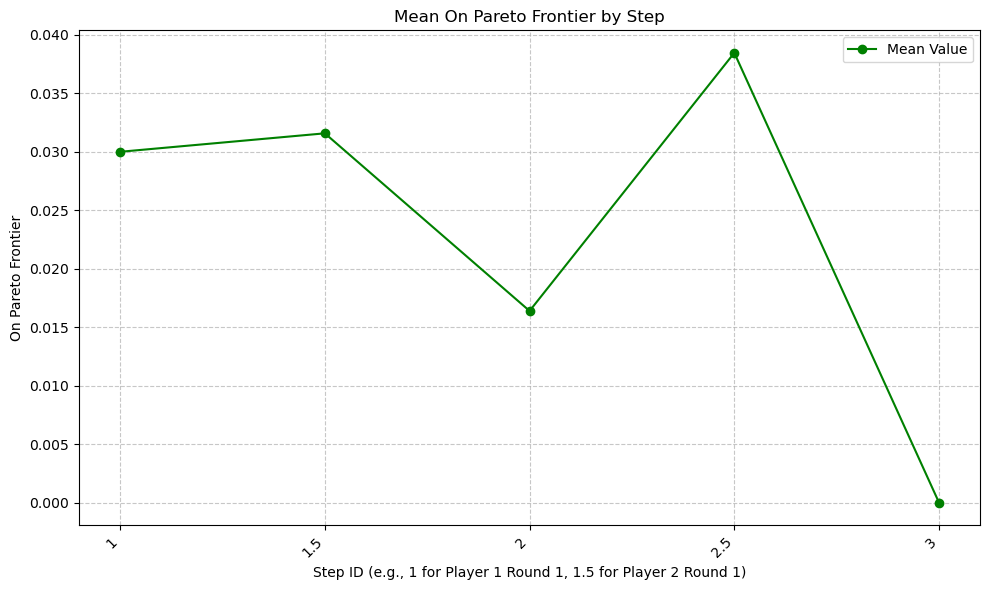

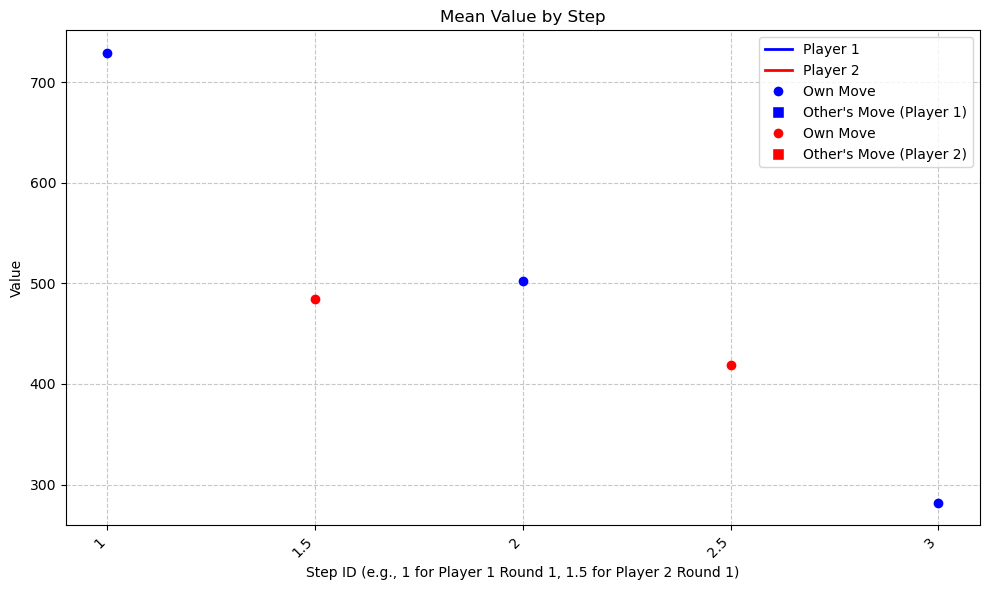

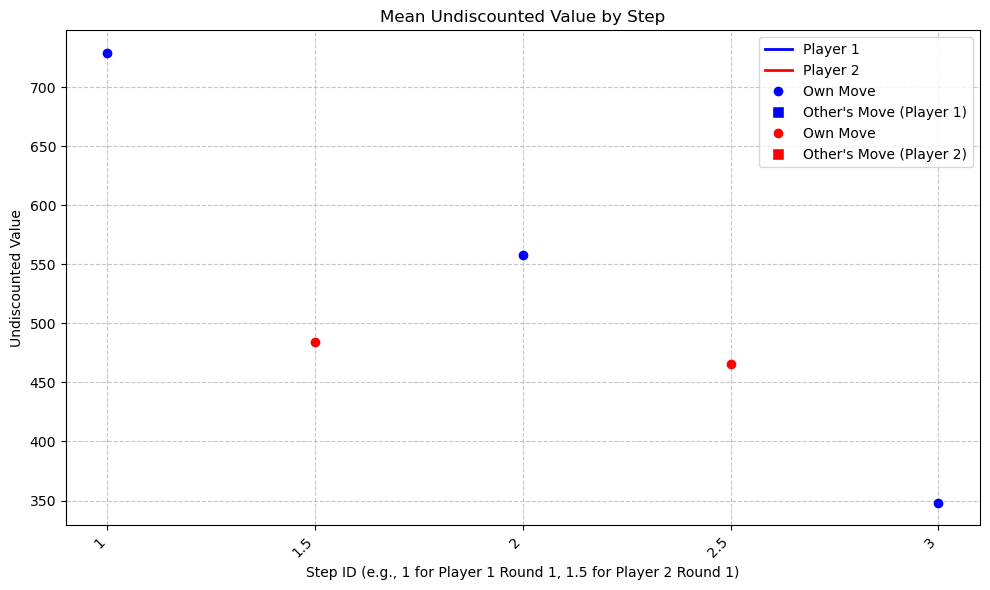

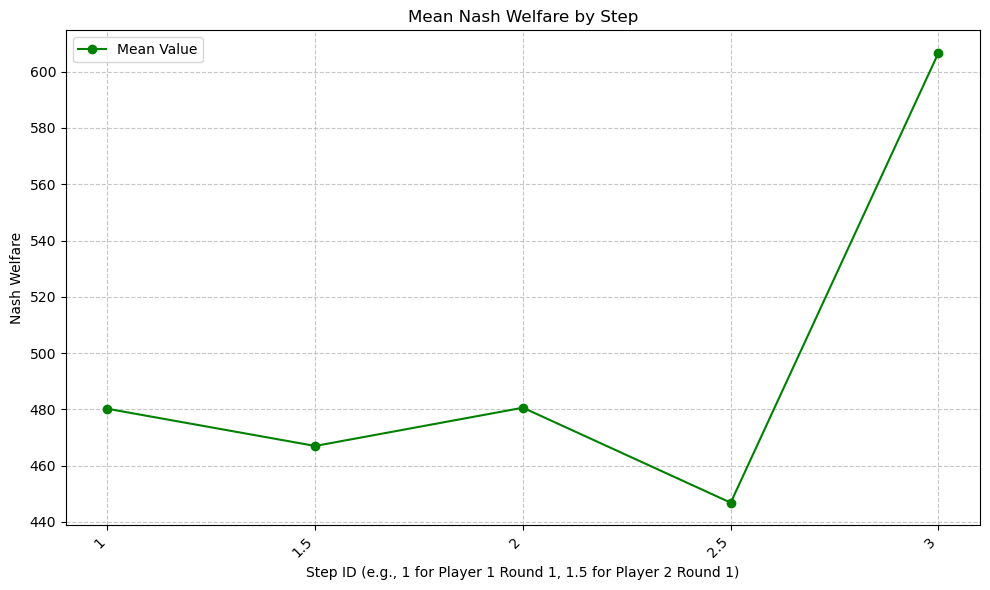

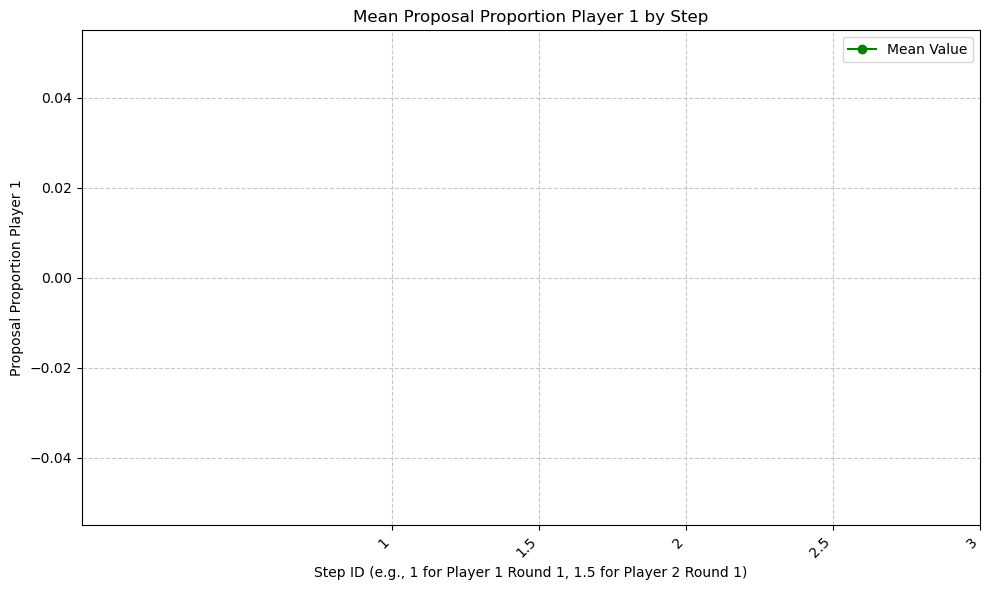

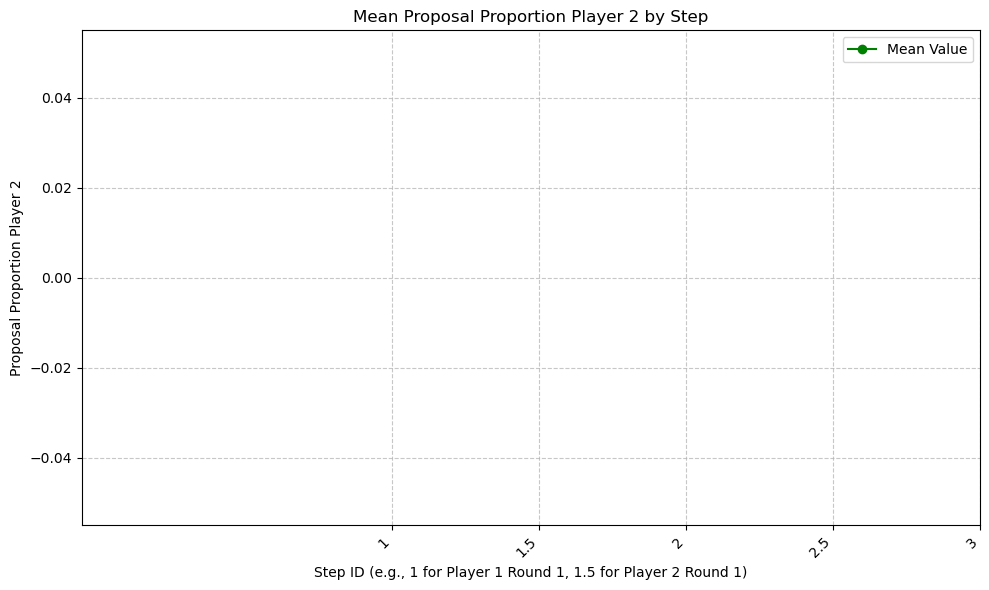

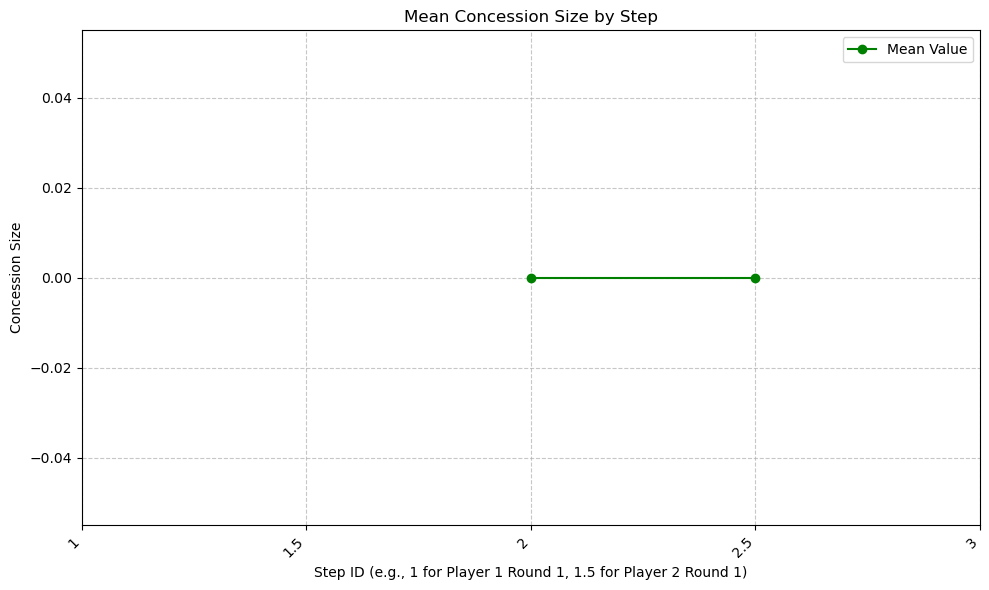

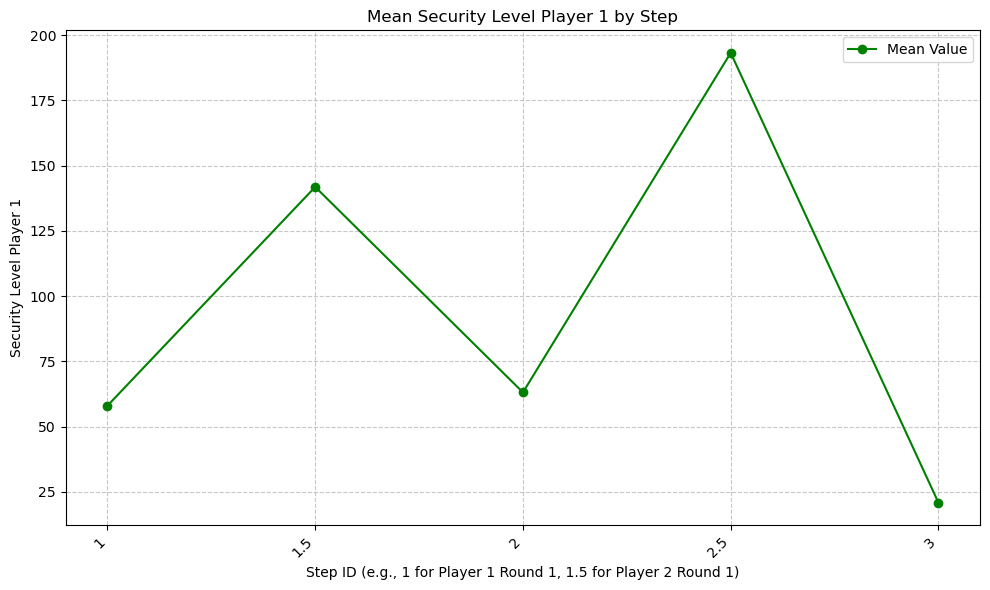

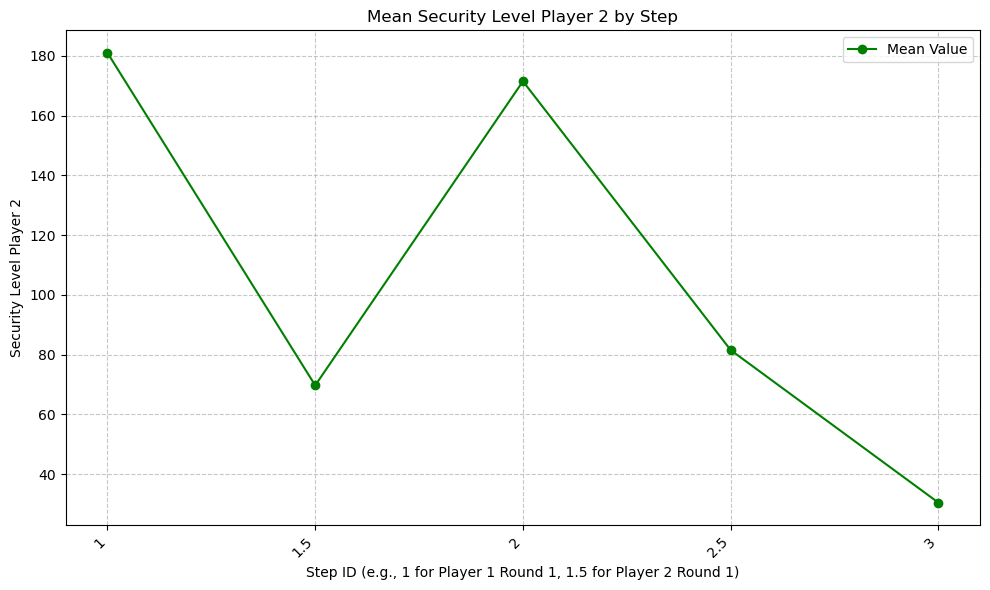

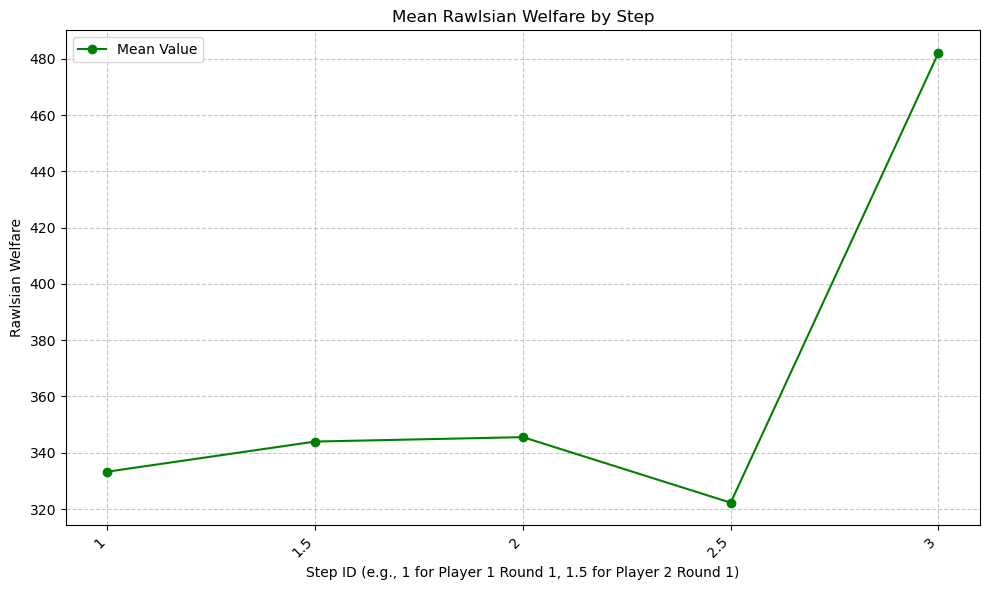

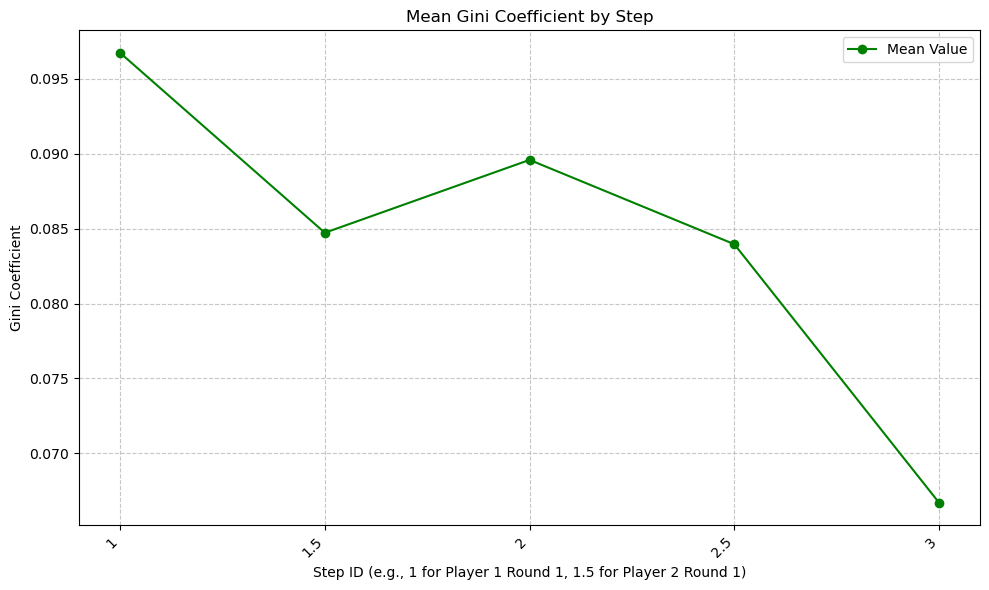

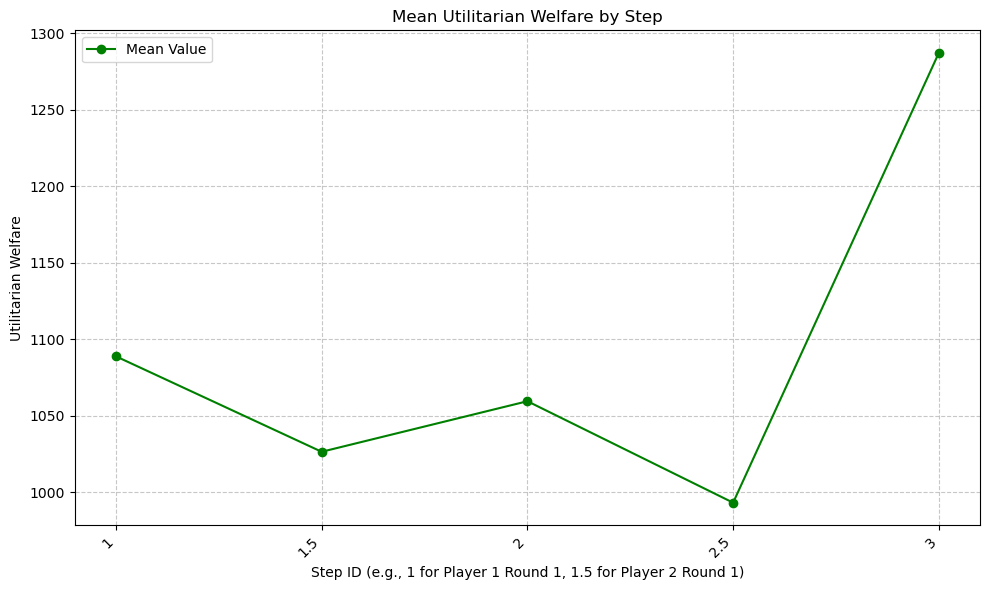

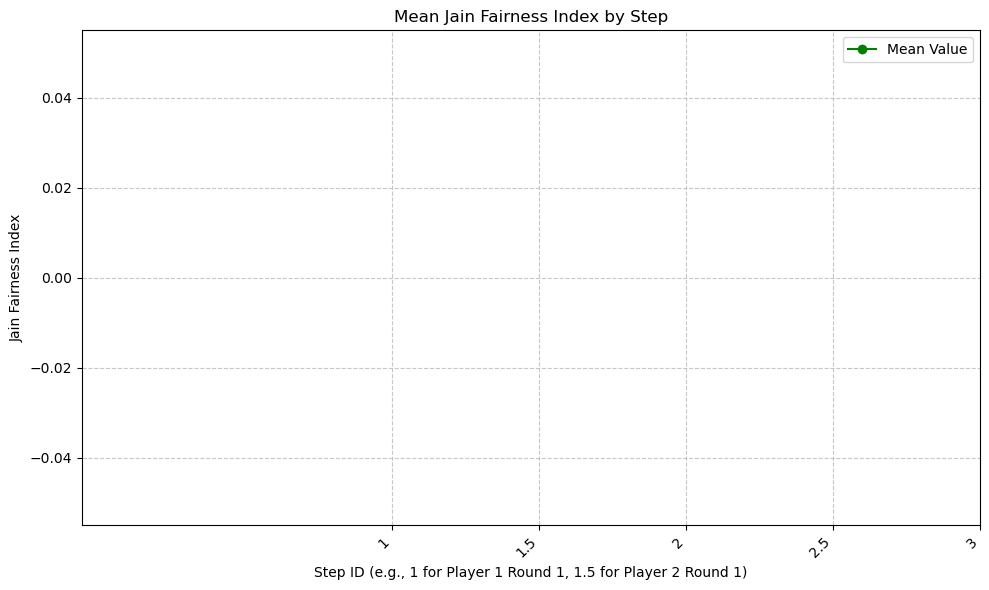

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def analyze_bargaining_statistics(csv_path):
    """
    Reads the CSV of game results (including welfare and bargaining stats),
    computes aggregate measures by step, and visualizes them in separate plots.
    
    Args:
        csv_path (str): Path to the CSV file.
    """

    # 1. Read the CSV into a DataFrame
    df = pd.read_csv(csv_path)

    # 2. Replace direct "None" strings or actual None with np.nan
    df = df.replace({None: np.nan, 'None': np.nan})

    # 3. Ensure 'round_num' and 'player' are numeric
    df['round_num'] = pd.to_numeric(df['round_num'], errors='coerce')
    df['player'] = pd.to_numeric(df['player'], errors='coerce')

    # 4. Compute step_id = round_num + 0.5*(player -1)
    df['step_id'] = df['round_num'] + 0.5 * (df['player'] - 1)
    df['step_id'] = pd.to_numeric(df['step_id'], errors='coerce')  # Ensure step_id is float

    # 5. Debugging: Print sample 'step_id' values
    print("Sample 'step_id' values:")
    print(df[['round_num', 'player', 'step_id']].head())

    # 6. Specify the numeric columns to analyze and visualize
    columns_of_interest = [
        "game_items",
        "offer", 
        "your_side_of_current_offer",
        "on_pareto_frontier",
        "value",
        "undiscounted_value",
        "nash_welfare",
        "proposal_proportion_player_1",
        "proposal_proportion_player_2",
        "concession_size",
        "security_level_player_1",
        "security_level_player_2",
        "rawlsian_welfare",
        "gini_coefficient",
        "utilitarian_welfare",
        "jain_fairness_index",
    ]
    
    # 7. Convert relevant columns to numeric, coerce errors -> NaN
    for col in columns_of_interest:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # 8. Sort DataFrame by 'step_id' to ensure proper ordering
    df = df.sort_values('step_id')

    # 9. Compute summary statistics by step_id (mean, std, etc.)
    group_by_step = df.groupby("step_id")
    summary_stats = {}
    for col in columns_of_interest:
        if col in df.columns:
            summary_stats[col] = {
                "mean": group_by_step[col].mean(),
                "std":  group_by_step[col].std(),
                "min":  group_by_step[col].min(),
                "max":  group_by_step[col].max()
            }
    print(f"Counts of step_ids: {df['step_id'].value_counts()}")
    # 10. Print out some aggregated summaries
    print("=== AGGREGATE STATISTICS BY STEP ===")
    print("Step |  Column                           |  Mean    |  Std     |  Min     |  Max")
    print("----------------------------------------------------------------------------------")
    unique_steps = sorted(df["step_id"].dropna().unique())
    print(f"Unique step_ids: {unique_steps}")  # Debugging
    for step in unique_steps:
        for col in columns_of_interest:
            if col in df.columns:
                col_stats = summary_stats[col]
                mean_val = col_stats["mean"].get(step, np.nan)
                std_val  = col_stats["std"].get(step, np.nan)
                min_val  = col_stats["min"].get(step, np.nan)
                max_val  = col_stats["max"].get(step, np.nan)
                print(f"{step:<5} | {col:<32} | {mean_val:8.2f} | {std_val:8.2f} | {min_val:8.2f} | {max_val:8.2f}")

    # 11. Create separate line plots for each column vs. step_id
    #count on pareto frontier
    on_pareto_frontier_count = df[df['on_pareto_frontier'] == True].groupby('step_id').size()
    print(f"Counts of on_pareto_frontier: {on_pareto_frontier_count}")
    columns_exist = [col for col in columns_of_interest if col in df.columns]

    #pareto optimal game ending
    pareto_optimal_game_ending = df[df['on_pareto_frontier'] == True].groupby('').size()
    print(f"Counts of pareto_optimal_game_ending: {pareto_optimal_game_ending}")
    
    for col in columns_exist:
        if col in ["value", "undiscounted_value"]:
            # Create a new figure for each plot
            plt.figure(figsize=(10, 6))
            
            # Filter data for Player 1 and Player 2
            player1 = df[df['player'] == 1]
            player2 = df[df['player'] == 2]
            
            # Group by step_id and compute mean
            player1_grouped = player1.groupby('step_id')[col].mean().reindex(unique_steps, fill_value=np.nan)
            player2_grouped = player2.groupby('step_id')[col].mean().reindex(unique_steps, fill_value=np.nan)
            
            # Plot Player 1
            plt.plot(player1_grouped.index, player1_grouped.values, label='Player 1', color='blue', linestyle='-', marker='o')
            # Overlay square markers for Player 1 when it's Player 2's move (step_ids 1.5, 2.5, 3.5)
            player1_other_moves = player1_grouped.loc[player1_grouped.index % 1 != 0]
            plt.scatter(player1_other_moves.index, player1_other_moves.values, color='blue', marker='s', label='Player 1 Other\'s Move')
            
            # Plot Player 2
            plt.plot(player2_grouped.index, player2_grouped.values, label='Player 2', color='red', linestyle='-', marker='o')
            # Overlay square markers for Player 2 when it's Player 1's move (step_ids 1, 2, 3)
            player2_other_moves = player2_grouped.loc[player2_grouped.index % 1 == 0]
            plt.scatter(player2_other_moves.index, player2_other_moves.values, color='red', marker='s', label='Player 2 Other\'s Move')
            
            # Set title and labels
            plt.title(f"Mean {col.replace('_', ' ').title()} by Step")
            plt.xlabel("Step ID (e.g., 1 for Player 1 Round 1, 1.5 for Player 2 Round 1)")
            plt.ylabel(col.replace('_', ' ').title())
            
            # Set x-ticks and labels
            step_labels = [f"{int(step)}" if step.is_integer() else f"{step:.1f}" for step in unique_steps]
            plt.xticks(unique_steps, step_labels, rotation=45, ha='right')
            
            # Add grid
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # Create custom legend to avoid duplicate labels
            custom_lines = [
                Line2D([0], [0], color='blue', lw=2, label='Player 1'),
                Line2D([0], [0], color='red', lw=2, label='Player 2'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Own Move'),
                Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=8, label='Other\'s Move (Player 1)'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Own Move'),
                Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=8, label='Other\'s Move (Player 2)'),
            ]
            plt.legend(handles=custom_lines, loc='best')
            
            # Adjust layout to prevent clipping of tick-labels
            plt.tight_layout()
            
            # Show the plot
            plt.show()
        else:
            # For other columns, plot as before
            # Create a new figure for each plot
            plt.figure(figsize=(10, 6))
            
            # Group by step_id and compute mean
            aggregated = group_by_step[col].mean().reindex(unique_steps, fill_value=np.nan)
    
            # Plot the data
            plt.plot(aggregated.index, aggregated.values, marker='o', linestyle='-', color='green', label='Mean Value')
            plt.title(f"Mean {col.replace('_', ' ').title()} by Step")
            plt.ylabel(col.replace('_', ' ').title())
            plt.xlabel("Step ID (e.g., 1 for Player 1 Round 1, 1.5 for Player 2 Round 1)")
            
            # Set x-ticks and labels
            step_labels = [f"{int(step)}" if step.is_integer() else f"{step:.1f}" for step in unique_steps]
            plt.xticks(unique_steps, step_labels, rotation=45, ha='right')
            
            # Add grid for better readability
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # Add legend
            plt.legend()
            
            # Adjust layout to prevent clipping of tick-labels
            plt.tight_layout()
            
            # Show the plot
            plt.show()

#analyze_bargaining_statistics(f"../experiments/pathology_results_{date}_{games}_{prompt_style}_circle_{circle}.csv")
analyze_bargaining_statistics(f"../experiments/pathology_results_1_23_2025_100_openai_o1_maximize_value_outside_offer_cot_1_test2_circle_0.csv")

## Statistics of Play for Each Player Over Games

In [21]:
# Read the CSV data
import pandas as pd
#/Users/gabesmithline/Desktop/caif_negotiation/experiments/2025_1_5/llama/basic_maximize_value_outside_offer_cot/pathology_results_1_5_2025_100_llama_3.1_405b_maximize_value_outside_offer_cot_.9.csv
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}_circle_{circle}.csv')
#df = pd.read_csv("/Users/gabesmithline/Desktop/caif_negotiation/experiments/2025_1_4/llama/basic_maximize_value_outside_offer_cot/pathology_results_1_4_2025_100_llama_3.1_405b_maximize_value_outside_offer_cot_1.csv")
def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()

    if is_game_ending_pathology:
        # Identify moves where the pathology occurred
        #pathology_moves = df[df[pathology_name]]
        pathology_moves = df[df[pathology_name].fillna(False)]

        # Get the first occurrence per game (since game ends after pathology)
        first_pathology_moves = pathology_moves.groupby('game_num').first().reset_index()

        # Overall count of games with the pathology
        overall_count = len(first_pathology_moves)

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {overall_count}/{total_games} ({(overall_count/total_games*100):.1f}%)")

        # Count per player
        player_counts = first_pathology_moves['player'].value_counts()

        for player in [1, 2]:
            player_count = player_counts.get(player, 0)
            print(f"Player {player}: {player_count}/{total_games} ({(player_count/total_games*100):.1f}%)")

        # Count per round
        round_counts = first_pathology_moves['round_num'].value_counts()
        for round_num in sorted(df['round_num'].unique()):
            round_count = round_counts.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_games} ({(round_count/total_games*100):.1f}%)")

    else:
        # Identify the first occurrence of a game-ending pathology per game
        game_ending_moves = df[df[['accepting_an_offer_worse_than_outside_offer',
                                   'walking_away_from_an_offer_better_than_your_outside_offer']].any(axis=1)]
        #first_game_ending_round = game_ending_moves.groupby('game_num')['round_num'].min()
        first_game_ending_indices = game_ending_moves.groupby('game_num').first().reset_index()['round_num']
        # Function to get valid moves (before any game-ending pathology occurs)
        def get_valid_moves(group):
            game_num = group['game_num'].iloc[0]
            if game_num in first_game_ending_indices.index:
                #pathology_round = first_game_ending_round.loc[game_num]
                first_pathology_index = first_game_ending_indices.loc[game_num]

                #return group[group['round_num'] < pathology_round]  # Exclude the pathology round and after
                return group[group['round_num'] < first_pathology_index]  # Exclude the pathology round and after
            else:
                return group  

        # Apply the function to get all valid moves before game-ending pathologies
        valid_moves = df.groupby('game_num').apply(get_valid_moves).reset_index(drop=True)

        total_moves = len(valid_moves)
        count = valid_moves[pathology_name].sum()

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {int(count)}/{total_moves} ({(count/total_moves*100):.1f}%)")

        # By Player
        for player in [1, 2]:
            player_moves = valid_moves[valid_moves['player'] == player]
            player_count = player_moves[pathology_name].sum()
            moves = len(player_moves)
            if moves > 0:
                print(f"Player {player}: {int(player_count)}/{moves} ({(player_count/moves*100):.1f}%)")

        # By Round
        for round_num in sorted(valid_moves['round_num'].unique()):
            round_moves = valid_moves[valid_moves['round_num'] == round_num]
            round_count = round_moves[pathology_name].sum()
            moves_in_round = len(round_moves)
            if moves_in_round > 0:
                print(f"Round {round_num}: {int(round_count)}/{moves_in_round} ({(round_count/moves_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 6/100 (6.0%)
Player 1: 3/100 (3.0%)
Player 2: 3/100 (3.0%)
Round 1: 1/100 (1.0%)
Round 2: 5/100 (5.0%)
Round 3: 0/100 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/100 (0.0%)
Player 1: 0/100 (0.0%)
Player 2: 0/100 (0.0%)
Round 1: 0/100 (0.0%)
Round 2: 0/100 (0.0%)
Round 3: 0/100 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 42/252 (16.7%)
Player 1: 24/151 (15.9%)
Player 2: 18/101 (17.8%)
Round 1: 34/186 (18.3%)
Round 2: 8/55 (14.5%)
Round 3: 0/11 (0.0%)

=== offer_no_items_or_all_items ===

Overall: 0/252 (0.0%)
Player 1: 0/151 (0.0%)
Player 2: 0/101 (0.0%)
Round 1: 0/186 (0.0%)
Round 2: 0/55 (0.0%)
Round 3: 0/11 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 1/252 (0.4%)
Player 1: 0/151 (0.0%)
Player 2: 1/101 (1.0%)
Round 1: 1/186 (0.5%)
Round 2: 0/55 (0.0%)
Round 3: 0/11 (0.0%)


## Compute Bargaining Metrics

=== AGGREGATE STATISTICS BY ROUND ===
Round |  Column                           |  Mean    |  Std     |  Min     |  Max
----------------------------------------------------------------------------------
1     | player                           |     1.47 |     0.50 |     1.00 |     2.00
1     | value                            |   647.59 |   285.64 |    82.00 |  1608.00
1     | undiscounted_value               |   647.59 |   285.64 |    82.00 |  1608.00
1     | nash_welfare                     |   507.43 |   162.06 |   142.97 |   927.32
1     | proposal_proportion_player_1     |      nan |      nan |      nan |      nan
1     | proposal_proportion_player_2     |      nan |      nan |      nan |      nan
1     | concession_size                  |      nan |      nan |      nan |      nan
1     | security_level_player_1          |    86.12 |   204.56 |     0.00 |  1357.00
1     | security_level_player_2          |   116.52 |   215.14 |     0.00 |  1327.00
1     | rawlsian_welfare        

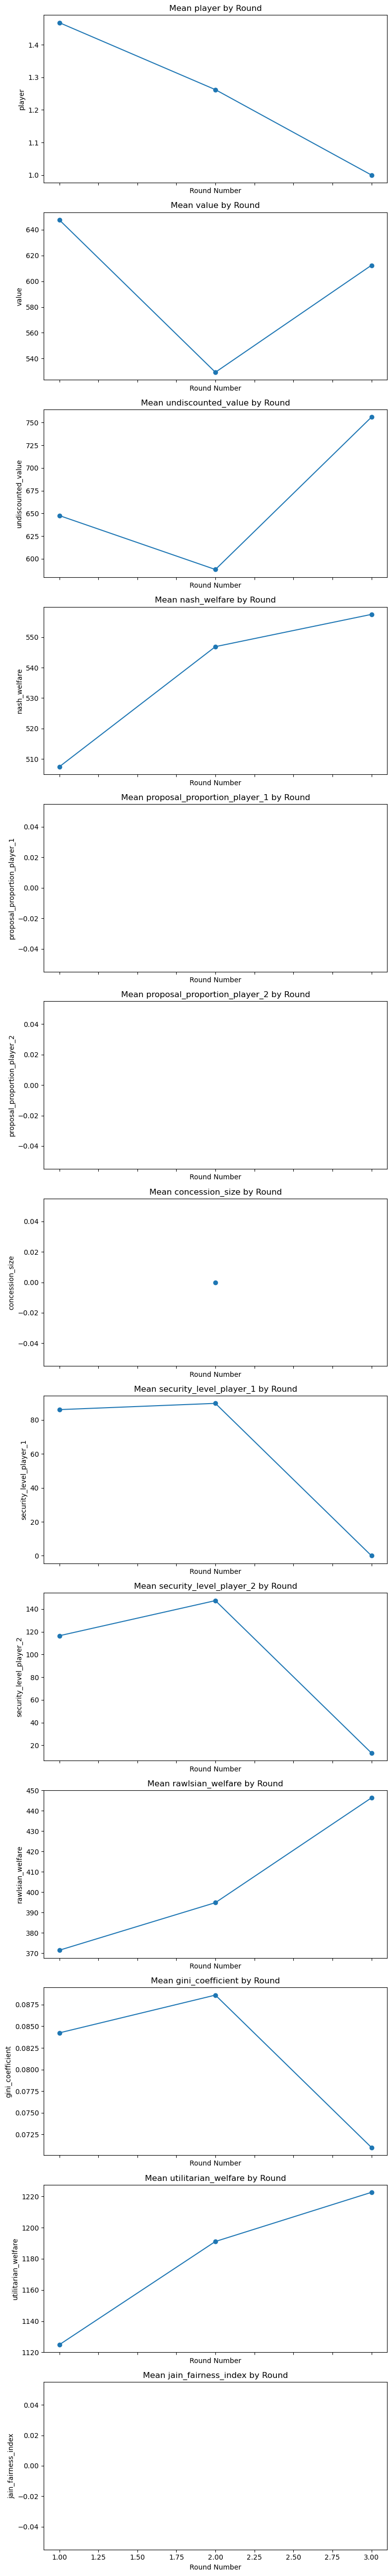

In [9]:
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}_circle_{circle}.csv')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_bargaining_statistics(csv_path):
    """
    Reads the CSV of game results (including welfare and bargaining stats),
    computes aggregate measures by round, and visualizes them.
    
    Args:
        csv_path (str): Path to the CSV file (e.g. "pathology_results_1_18_2025_3_openai_o1_maximize_value_outside_offer_cot_1_test.csv")
    """

    # 1. Read the CSV into a DataFrame
    df = pd.read_csv(csv_path)

    # 2. Replace direct "None" strings or actual None with np.nan
    #    so that pandas can skip them appropriately in calculations.
    df = df.replace({None: np.nan, 'None': np.nan})

    # 3. Specify the numeric columns we wish to analyze and visualize
    #    (feel free to add/remove as needed from your dataset).
    columns_of_interest = [
        "player",
        "value",
        "undiscounted_value",
        "nash_welfare",
        "proposal_proportion_player_1",
        "proposal_proportion_player_2",
        "concession_size",
        "security_level_player_1",
        "security_level_player_2",
        "rawlsian_welfare",
        "gini_coefficient",
        "utilitarian_welfare",
        "jain_fairness_index",
        
    ]
    
    # 4. Convert relevant columns to numeric, coerce errors -> NaN
    for col in columns_of_interest:
        
        if col in df.columns and col not in ["game_num", "round_num", "player"]:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 5. Compute summary statistics by round (mean, std, etc.)
    #    This will skip NaN by default (skipna=True).
    group_by_round = df.groupby("round_num")
    summary_stats = {}
    for col in columns_of_interest:
        if col in df.columns:
            summary_stats[col] = {
                "mean": group_by_round[col].mean(),
                "std":  group_by_round[col].std(),
                "min":  group_by_round[col].min(),
                "max":  group_by_round[col].max()
            }
    
    # 6. Print out some aggregated summaries
    print("=== AGGREGATE STATISTICS BY ROUND ===")
    print("Round |  Column                           |  Mean    |  Std     |  Min     |  Max")
    print("----------------------------------------------------------------------------------")
    unique_rounds = sorted(df["round_num"].dropna().unique())
    for rnd in unique_rounds:
        for col in columns_of_interest:
            if col in df.columns:
                col_stats = summary_stats[col]
                mean_val = col_stats["mean"].get(rnd, np.nan)
                std_val  = col_stats["std"].get(rnd, np.nan)
                min_val  = col_stats["min"].get(rnd, np.nan)
                max_val  = col_stats["max"].get(rnd, np.nan)
                print(f"{rnd:<5} | {col:<32} | {mean_val:8.2f} | {std_val:8.2f} | {min_val:8.2f} | {max_val:8.2f}")
    
    # 7. Create line plots for each column vs. round_num
    #    Only plot if the column actually exists in the DataFrame.
    columns_exist = [col for col in columns_of_interest if col in df.columns]
    nrows = len(columns_exist)
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(8, 4 * nrows), sharex=True)
    
    # If there's only one column, axes won't be an array
    if nrows == 1:
        axes = [axes]
    
    for ax, col in zip(axes, columns_exist):
        aggregated = group_by_round[col].mean()  # skipna=True by default
        ax.plot(aggregated.index, aggregated.values, marker='o')
        ax.set_title(f"Mean {col} by Round")
        ax.set_xlabel("Round Number")
        
        ax.set_ylabel(col)
    
    plt.tight_layout()
    plt.show()


analyze_bargaining_statistics(f"../experiments/pathology_results_{date}_{games}_{prompt_style}_circle_{circle}.csv")



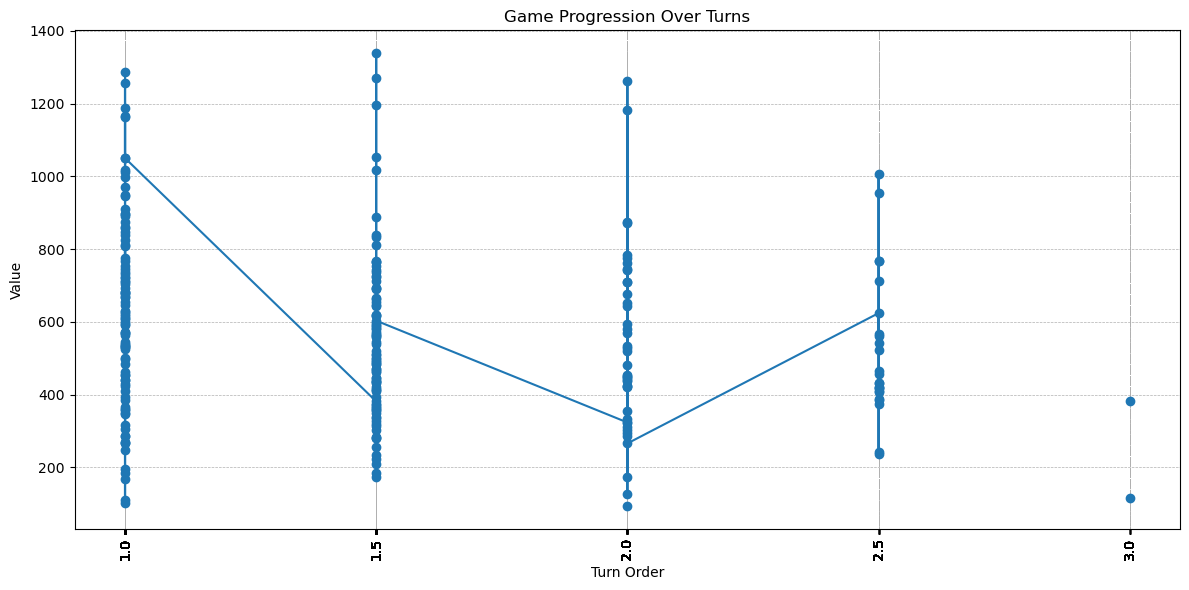

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the game results
# If not already loaded, read the CSV file
df = pd.read_csv('../experiments/pathology_results_1_23_2025_100_openai_o1_maximize_value_outside_offer_cot_1_test2_circle_3.csv')

# Convert string representations of lists to actual lists if necessary
import ast
df['offer'] = df['offer'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)

# Create a 'turn_order' column where:
# - Player 1's moves are integers (1, 2, 3, ...)
# - Player 2's moves are at .5 increments (1.5, 2.5, 3.5, ...)
df['turn_order'] = df['round_num'] + (df['player'] - 1) * 0.5

# Sort the DataFrame by 'turn_order' to ensure correct plotting order
df.sort_values('turn_order', inplace=True)

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot a metric of interest against 'turn_order'
# Replace 'value' with the actual column you wish to plot
plt.plot(df['turn_order'], df['value'], marker='o', linestyle='-')

# Customize the x-axis
plt.xlabel('Turn Order')
plt.xticks(df['turn_order'], rotation=90)
plt.ylabel('Value')  # Replace with your metric's name
plt.title('Game Progression Over Turns')

# Optional: Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

## Compute Envy Free Results By Game

In [11]:
#Loop through envy_results_history and compute envy free results
envy_results_by_game = pd.DataFrame()
envy_results_by_game.columns = pd.DataFrame(columns=[ #Set up dataframe to store game pathology results
        "game_num", "outside_offer_consistency", "offer_increasing", "envy_free_strict", "envy_free_exclude_one_item"
    ])
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    evaluator = GameEvaluator(game)
    print(f"Outside offer consistency: {evaluator.evaluate_outside_offer_consistency()}")
    print(f"Offer increasing: {evaluator.evaluate_offer_increasing()}")
    print(f"Envy-free (strict): {evaluator.evaluate_envy_free()}")
    print(f"Envy-free (exclude one item): {evaluator.evaluate_envy_free(exclude_one_item=True)}")
    envy_results_by_game = pd.concat([envy_results_by_game, pd.DataFrame([{
        "game_num": i, "outside_offer_consistency": evaluator.evaluate_outside_offer_consistency(),
        "offer_increasing": evaluator.evaluate_offer_increasing(), "envy_free_strict": evaluator.evaluate_envy_free(),
        "envy_free_exclude_one_item": evaluator.evaluate_envy_free(exclude_one_item=True)
    }])], ignore_index=True)

#percentage of games that are envy free
print(f"Envy free (strict): {envy_results_by_game['envy_free_strict'].value_counts() / len(envy_results_by_game)}")
print(f"Envy free (exclude one item): {envy_results_by_game['envy_free_exclude_one_item'].value_counts() / len(envy_results_by_game)}")
print(f"Outside offer consistency: {envy_results_by_game['outside_offer_consistency'].value_counts() / len(envy_results_by_game)}")
print(f"Offer increasing: {envy_results_by_game['offer_increasing'].value_counts() / len(envy_results_by_game)}")



Game 1:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 2:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 3:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 4:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 5:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 6:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): False
Envy-free (exclude one item): False
Game 7:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 8:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 9:
O

## Envy Free Results by Player

In [12]:
envy_results_history_copy = envy_results_history.copy()
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    print(f"Game History Values:")
    for player in [0, 1]:
        player_offers = game.get_offers(player)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        outside_value = game.agent_1_outside_value if player == 0 else game.agent_2_outside_value
        
        print(f"\nPlayer {player + 1}:")
        print(f"Outside offer value: {outside_value}")
        
        for i, offer in enumerate(player_offers):
            given_value = torch.dot(player_values, offer.offer)
            total_value = torch.dot(player_values, game.items)
            kept_value = total_value - given_value
            
            print(f"Offer {i + 1}:")
            print(f"  Offer: {offer.offer}")
            print(f"  Player values: {player_values}")
            print(f"  Value calculation:")
            print(f"    Total value: {total_value.item()} = {player_values} · {game.items}")
            print(f"    Given value: {given_value.item()} = {player_values} · {offer.offer}")
            print(f"    Kept value: {kept_value.item()} = {total_value.item()} - {given_value.item()}")
            print(f"  Value of kept items: {kept_value.item()}")

    print("\nEnvy-free evaluation details:")
    for player in [0, 1]:
        opponent = 1 - player
        player_offers = game.get_offers(player)
        opponent_offers = game.get_offers(opponent)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        
        print(f"\nPlayer {player + 1}:")
        for i, offer in enumerate(player_offers):
            if i < len(opponent_offers):
                opp_offer = opponent_offers[i]
                player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                
                print(f"Round {i + 1}:")
                print(f"  Player's offer: {offer.offer}")
                print(f"  Opponent's offer: {opp_offer.offer}")
                print(f"  Player's bundle value: {player_bundle_value.item()} = {player_values} · ({game.items} - {offer.offer})")
                print(f"  Opponent's bundle value (to player): {opponent_bundle_value.item()} = {player_values} · ({game.items} - {opp_offer.offer})")
                
                if player_bundle_value >= opponent_bundle_value:
                    print("  Envy-free: Yes")
                else:
                    print("  Envy-free: No")
                    print("  Checking if removing one item makes it envy-free:")
                    for j in range(len(game_history.items)):
                        temp_opp_offer = opp_offer.offer.clone()
                        if temp_opp_offer[j] > 0:
                            temp_opp_offer[j] -= 1
                            temp_opponent_bundle_value = torch.dot(player_values, game.items - temp_opp_offer)
                            print(f"    Removing item {j + 1}: {temp_opponent_bundle_value.item()} = {player_values} · ({game.items} - {temp_opp_offer})")
                            if player_bundle_value >= temp_opponent_bundle_value:
                                print(f"    Envy-free after removing item {j + 1}: Yes")
                                break
                    else:
                        print("    Envy-free after removing any single item: No")


Game 1:
Game History Values:

Player 1:
Outside offer value: 166
Offer 1:
  Offer: tensor([2, 1, 3, 1, 3])
  Player values: tensor([43, 26, 34, 94, 22])
  Value calculation:
    Total value: 939 = tensor([43, 26, 34, 94, 22]) · tensor([5, 3, 6, 4, 3])
    Given value: 374 = tensor([43, 26, 34, 94, 22]) · tensor([2, 1, 3, 1, 3])
    Kept value: 565 = 939 - 374
  Value of kept items: 565

Player 2:
Outside offer value: 103
Offer 1:
  Offer: tensor([3, 1, 3, 1, 1])
  Player values: tensor([63, 69, 85, 76,  6])
  Value calculation:
    Total value: 1354 = tensor([63, 69, 85, 76,  6]) · tensor([5, 3, 6, 4, 3])
    Given value: 595 = tensor([63, 69, 85, 76,  6]) · tensor([3, 1, 3, 1, 1])
    Kept value: 759 = 1354 - 595
  Value of kept items: 759
Offer 2:
  Offer: tensor([2, 1, 3, 1, 3])
  Player values: tensor([63, 69, 85, 76,  6])
  Value calculation:
    Total value: 1354 = tensor([63, 69, 85, 76,  6]) · tensor([5, 3, 6, 4, 3])
    Given value: 544 = tensor([63, 69, 85, 76,  6]) · tensor(

In [13]:
print("Checking envy_results_history structure:")
print(f"Type: {type(envy_results_history_copy.items())}")
print(f"Length: {len(envy_results_history_copy.items())}")
if len(envy_results_history_copy.items()) > 0:
    first_game = next(iter(envy_results_history_copy.items()))[1]
    print("\nFirst game attributes:")
    print(f"Has items: {hasattr(first_game, 'items')}")
    print(f"Has agent_1_values: {hasattr(first_game, 'agent_1_values')}")
    print(f"Has agent_1_outside_value: {hasattr(first_game, 'agent_1_outside_value')}")
    print(f"Has get_offers method: {hasattr(first_game, 'get_offers')}")
    if hasattr(first_game, 'get_offers'):
        print(f"Number of offers player 1: {len(first_game.get_offers(0))}")
        print(f"Number of offers player 2: {len(first_game.get_offers(1))}")

Checking envy_results_history structure:
Type: <class 'dict_items'>
Length: 100

First game attributes:
Has items: True
Has agent_1_values: True
Has agent_1_outside_value: True
Has get_offers method: True
Number of offers player 1: 1
Number of offers player 2: 2


In [14]:
#TODO: Move this to metrics/envy_free_analysis.py
def analyze_envy_freeness_comprehensive(game_history):
    total_games = len(game_history)
    moves_data = []
    game_properties = []
    
    for game_id, game in game_history.items():
        evaluator = GameEvaluator(game)
        max_round = max(len(game.get_offers(0)), len(game.get_offers(1)))
        
        # Track game-level properties
        is_outside_consistent = evaluator.evaluate_outside_offer_consistency()
        is_offer_increasing = evaluator.evaluate_offer_increasing()
        is_final_allocation = evaluator.evaluate_envy_free()
        is_final_one_item_ef = evaluator.evaluate_envy_free(exclude_one_item=True)
        
        game_properties.append({
            'game_num': game_id,
            'rounds_played': max_round,
            'outside_consistent': is_outside_consistent,
            'offer_increasing': is_offer_increasing
        })
        
        for round_num in range(max_round):
            steps_in_round = 0
            for player in [0, 1]:
                opponent = 1 - player
                player_offers = game.get_offers(player)
                opponent_offers = game.get_offers(opponent)
                
                is_last_step = (round_num == max_round - 1 and 
                              round_num >= len(opponent_offers) - 1)
                
                if round_num < len(player_offers):
                    steps_in_round += 1
                    player_values = game.agent_1_values if player == 0 else game.agent_2_values
                    offer = player_offers[round_num]
                    
                    if round_num < len(opponent_offers):
                        opp_offer = opponent_offers[round_num]
                        player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                        opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                        
                        is_strict_ef = bool(player_bundle_value >= opponent_bundle_value)
                        is_one_item_ef = False
                        
                        if not is_strict_ef:
                            for j in range(len(game.items)):
                                temp_opp_offer = opp_offer.offer.clone()
                                if temp_opp_offer[j] > 0:
                                    temp_opp_offer[j] -= 1
                                    temp_value = torch.dot(player_values, game.items - temp_opp_offer)
                                    if player_bundle_value >= temp_value:
                                        is_one_item_ef = True
                                        break
                        
                        moves_data.append({
                            'game_num': game_id,
                            'round_num': round_num + 1,
                            'step_num': steps_in_round,
                            'player': player + 1,
                            'is_strict_ef': is_strict_ef,
                            'is_one_item_ef': is_one_item_ef,
                            'is_final_allocation': is_last_step,
                            'final_strict_ef': is_final_allocation if is_last_step else False,
                            'final_one_item_ef': is_final_one_item_ef if is_last_step else False,
                            'outside_consistent': is_outside_consistent,
                            'offer_increasing': is_offer_increasing
                        })
    
    df = pd.DataFrame(moves_data)
    game_props_df = pd.DataFrame(game_properties)
    
    def print_stats(group, name):
        strict_ef_count = group['is_strict_ef'].sum()
        one_item_ef_count = group['is_one_item_ef'].sum()
        outside_consistent_count = group['outside_consistent'].sum()
        offer_increasing_count = group['offer_increasing'].sum()
        count = len(group)
        
        print(f"\n=== {name} ===")
        print(f"Count: {count}")
        print(f"Strict Envy-Free: {strict_ef_count}/{count} ({(strict_ef_count/count*100):.1f}%)")
        print(f"One-Item Envy-Free: {one_item_ef_count}/{count} ({(one_item_ef_count/count*100):.1f}%)")
        print(f"Outside Offer Consistent: {outside_consistent_count}/{count} ({(outside_consistent_count/count*100):.1f}%)")
        print(f"Offer Increasing: {offer_increasing_count}/{count} ({(offer_increasing_count/count*100):.1f}%)")
    
    print("\nGAME LENGTH STATISTICS")
    print(f"Average rounds per game: {game_props_df['rounds_played'].mean():.1f}")
    print(f"Max rounds in any game: {game_props_df['rounds_played'].max()}")
    print(f"Min rounds in any game: {game_props_df['rounds_played'].min()}")
    
    # Overall game properties
    print("\nOVERALL GAME PROPERTIES")
    print(f"Outside Offer Consistent: {game_props_df['outside_consistent'].sum()}/{total_games} ({(game_props_df['outside_consistent'].sum()/total_games*100):.1f}%)")
    print(f"Offer Increasing: {game_props_df['offer_increasing'].sum()}/{total_games} ({(game_props_df['offer_increasing'].sum()/total_games*100):.1f}%)")
    
    # Overall statistics
    print("\nOVERALL STATISTICS")
    print(f"Total Games: {total_games}")
    print(f"Total Moves: {len(df)}")
    
    # Final allocation statistics
    final_moves = df[df['is_final_allocation']]
    final_strict = final_moves.groupby('game_num')['final_strict_ef'].any()
    final_one_item = final_moves.groupby('game_num')['final_one_item_ef'].any()
    
    print("\nFINAL ALLOCATION STATISTICS")
    print(f"Strict Envy-Free: {final_strict.sum()}/{total_games} ({(final_strict.sum()/total_games*100):.1f}%)")
    print(f"One-Item Envy-Free: {final_one_item.sum()}/{total_games} ({(final_one_item.sum()/total_games*100):.1f}%)")
    
    # By Player
    for player in [1, 2]:
        player_moves = df[df['player'] == player]
        print_stats(player_moves, f"Player {player}")
    
    # By Round
    for round_num in sorted(df['round_num'].unique()):
        round_moves = df[df['round_num'] == round_num]
        print_stats(round_moves, f"Round {round_num}")
        
        # By Step within Round
        for step_num in sorted(round_moves['step_num'].unique()):
            step_moves = round_moves[round_moves['step_num'] == step_num]
            print_stats(step_moves, f"Round {round_num} - Step {step_num}")
        
        # By Player within Round
        for player in [1, 2]:
            player_round_moves = round_moves[round_moves['player'] == player]
            print_stats(player_round_moves, f"Round {round_num} - Player {player}")

    return df

envy_stats_df = analyze_envy_freeness_comprehensive(envy_results_history_copy)  
#save to csv
envy_stats_df.to_csv(f'envy_stats_df_{date}_{games}_{prompt_style}.csv', index=False)



GAME LENGTH STATISTICS
Average rounds per game: 1.3
Max rounds in any game: 3
Min rounds in any game: 0

OVERALL GAME PROPERTIES
Outside Offer Consistent: 45/100 (45.0%)
Offer Increasing: 99/100 (99.0%)

OVERALL STATISTICS
Total Games: 100
Total Moves: 208

FINAL ALLOCATION STATISTICS
Strict Envy-Free: 59/100 (59.0%)
One-Item Envy-Free: 59/100 (59.0%)

=== Player 1 ===
Count: 104
Strict Envy-Free: 69/104 (66.3%)
One-Item Envy-Free: 0/104 (0.0%)
Outside Offer Consistent: 46/104 (44.2%)
Offer Increasing: 103/104 (99.0%)

=== Player 2 ===
Count: 104
Strict Envy-Free: 72/104 (69.2%)
One-Item Envy-Free: 0/104 (0.0%)
Outside Offer Consistent: 46/104 (44.2%)
Offer Increasing: 103/104 (99.0%)

=== Round 1 ===
Count: 176
Strict Envy-Free: 123/176 (69.9%)
One-Item Envy-Free: 0/176 (0.0%)
Outside Offer Consistent: 84/176 (47.7%)
Offer Increasing: 174/176 (98.9%)

=== Round 1 - Step 1 ===
Count: 88
Strict Envy-Free: 59/88 (67.0%)
One-Item Envy-Free: 0/88 (0.0%)
Outside Offer Consistent: 42/88 (47

## Statistics 

In [15]:
# Statistics of Envy Free Results
import pandas as pd
import torch
def compute_statistics(envy_results_history):
    # Initialize dictionaries to store statistics
    game_stats = []
    round_stats = []
    player_stats = []
    
    print(f"Number of games in history: {len(envy_results_history)}")  # Debug print
    
    for game_id, game in envy_results_history.items():
        print(f"Processing game {game_id + 1}")  # Debug print
        
        # Game level statistics
        game_data = {
            'game_id': game_id + 1,
            'total_rounds': len(game.get_offers(0)),
            'player1_outside_value': game.agent_1_outside_value,
            'player2_outside_value': game.agent_2_outside_value,
            'total_items': len(game.items)
        }
        game_stats.append(game_data)
        
        # Process each player's offers and values
        for player in [0, 1]:
            player_offers = game.get_offers(player)
            player_values = game.agent_1_values if player == 0 else game.agent_2_values
            opponent = 1 - player
            opponent_offers = game.get_offers(opponent)
            
            print(f"  Player {player + 1} has {len(player_offers)} offers")  # Debug print
            
            # Player level statistics
            player_data = {
                'game_id': game_id + 1,
                'player_id': player + 1,
                'total_value': torch.dot(player_values, game.items).item(),
                'outside_value': game.agent_1_outside_value if player == 0 else game.agent_2_outside_value,
                'num_offers': len(player_offers)
            }
            player_stats.append(player_data)
            
            # Round level statistics
            for round_id, (offer, opp_offer) in enumerate(zip(player_offers, opponent_offers)):
                given_value = torch.dot(player_values, offer.offer).item()
                kept_value = torch.dot(player_values, game.items - offer.offer).item()
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer).item()
                
                is_envy_free = kept_value >= opponent_bundle_value
                
                round_data = {
                    'game_id': game_id + 1,
                    'round_id': round_id + 1,
                    'player_id': player + 1,
                    'given_value': given_value,
                    'kept_value': kept_value,
                    'opponent_bundle_value': opponent_bundle_value,
                    'is_envy_free': is_envy_free
                }
                round_stats.append(round_data)
    
    print(f"\nStatistics summary:")  # Debug prints
    print(f"Number of game records: {len(game_stats)}")
    print(f"Number of player records: {len(player_stats)}")
    print(f"Number of round records: {len(round_stats)}")
    
    # Convert to DataFrames and save to CSV
    game_df = pd.DataFrame(game_stats)
    round_df = pd.DataFrame(round_stats)
    player_df = pd.DataFrame(player_stats)
    
    # Save to CSV files
    game_df.to_csv('game_statistics.csv', index=False)
    round_df.to_csv('round_statistics.csv', index=False)
    player_df.to_csv('player_statistics.csv', index=False)
    
    # Print first few rows of each DataFrame
    print("\nFirst few rows of game statistics:")
    print(game_df.head())
    print("\nFirst few rows of player statistics:")
    print(player_df.head())
    print("\nFirst few rows of round statistics:")
    print(round_df.head())
    
    return game_df, round_df, player_df

game_df, round_df, player_df = compute_statistics(envy_results_history)


Number of games in history: 100
Processing game 1
  Player 1 has 1 offers
  Player 2 has 2 offers
Processing game 2
  Player 1 has 1 offers
  Player 2 has 2 offers
Processing game 3
  Player 1 has 2 offers
  Player 2 has 2 offers
Processing game 4
  Player 1 has 2 offers
  Player 2 has 2 offers
Processing game 5
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 6
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 7
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 8
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 9
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 10
  Player 1 has 1 offers
  Player 2 has 2 offers
Processing game 11
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 12
  Player 1 has 1 offers
  Player 2 has 2 offers
Processing game 13
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 14
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 15
  Player 1 has 1 off

In [16]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

# Add the main project directory to sys.path
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  # Run the notebook directly
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

# Initialize the DataFrame to store pathology results
pathology_results = pd.DataFrame()  # Store total game pathology results
# Add COLUMNS
envy_results_history = {}

Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



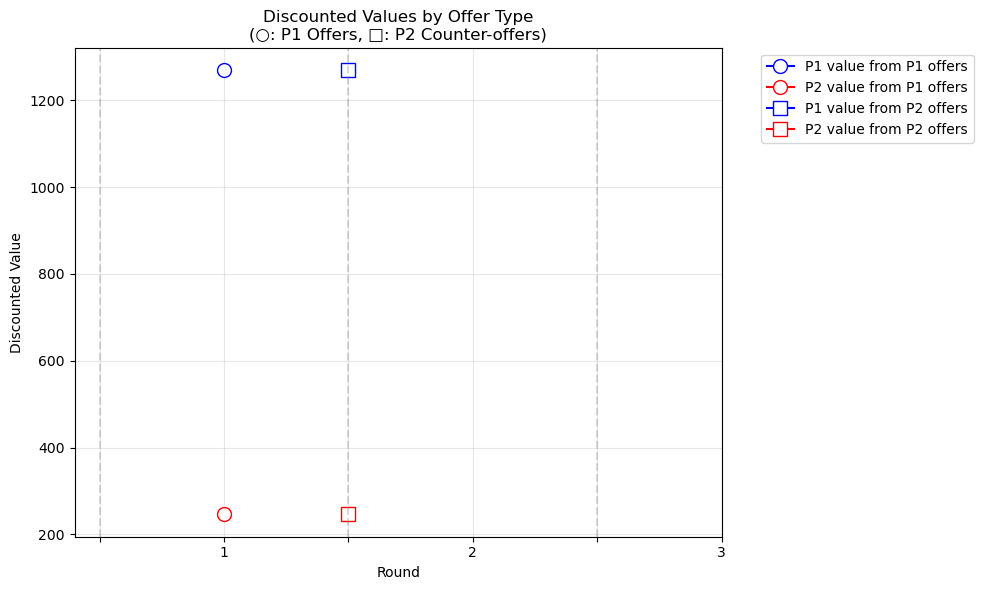

In [17]:
plot_discounted_values(rounds, p1_values, p2_values, max_rounds)


## Offer Evolution Plot

This visualization shows how the distribution of items changes over the negotiation rounds, with a separate subplot for each item type.

### Layout
- Creates a grid of subplots (2 columns)
- One subplot per item type
- For odd number of items, removes unused subplot

### Per Item Subplot
- X-axis: Negotiation rounds
- Y-axis: Number of units offered to P2
- Blue line (○): P1's offers
- Red line (○): P2's counter-offers
- Y-axis range: 0 to maximum units available for that item
- Grid shows valid integer unit values

### Interpretation
- Shows how many units of each item type each player offered to give to P2
- P1's remaining units = total_items - offered_units
- Converging lines suggest agreement being reached
- Diverging lines suggest areas of contention

Number of rounds: 2
Number of P1 offers: 1
Number of P2 offers: 1


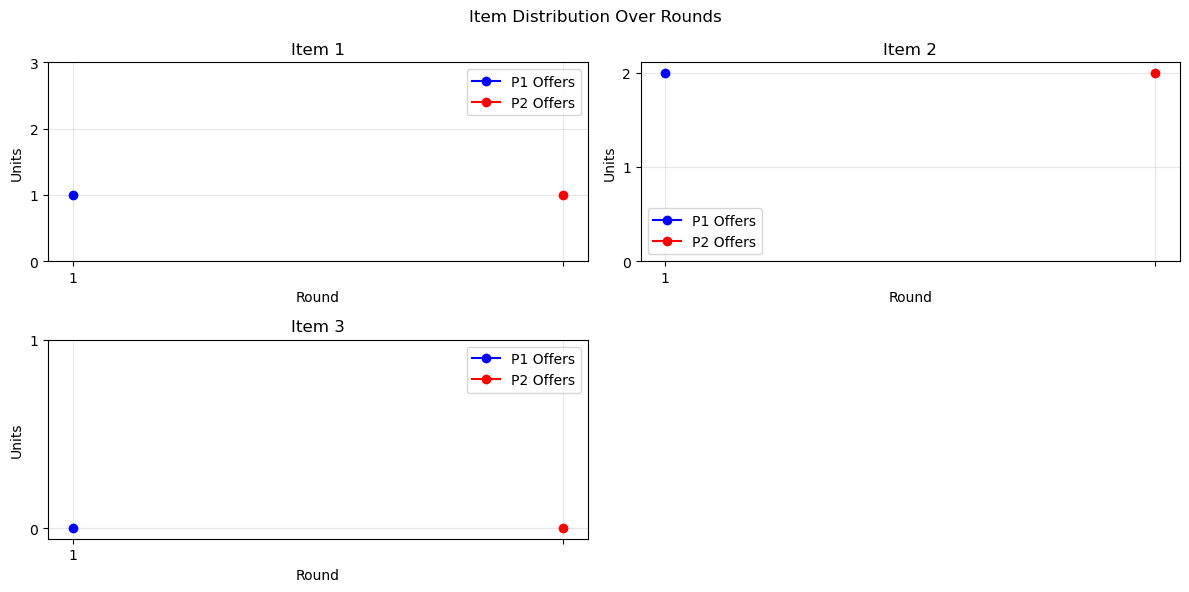

In [18]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

In [19]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

if game.current_offer:
    final_division = get_final_division(game)
    value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)] 
    fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  

    print("\nBasic Metrics:")
    print(f"Final P1 Value: {p1_values[-1]:.2f}")
    print(f"Final P2 Value: {p2_values[-1]:.2f}")
    print(f"Final Value Gap: {value_gaps[-1]:.2f}")
    print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
    print("\nFinal Division of Items:")
    if final_division:
        print(f"Total Items Available: {game.items}")
        print(f"P1 Received: {final_division['P1']}")
        print(f"P2 Received: {final_division['P2']}")
    else:
        print("No deal reached - no items were divided")

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print(f"P1 Valuation of Each Item: {game.player_values[0]}")
print(f"P2 Valuation of Each Item: {game.player_values[1]}")

RuntimeError: dot : expected both vectors to have same dtype, but found Float and Long

## Check Pathologies
- Check if Pathologies Occured
- Check Count in game 
- Save to csv
